# NSSP Projet 2

## PART 1 : Single subject classification

In this part of the mini-project, you will use NinaPro Dataset 1 to classify and predict the movement classes
associated to the different EMG signals for a single subject. The participants are tasked
to replicate the movement shown on the screen. Surface EMG signals are recorded while the
participants perform the tasks.

First, we import packages and load the subject two.

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#set the random seed
random_seed = 42
import random
random.seed(42)

#### Load subject 2

In [2]:
data = loadmat("data/s2/S2_A1_E1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


### 1 Visualize and preprocess the data

Let's load the emg, stimulus and repetition data and check the shapes.

In [3]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

stimulus = data["restimulus"] 
repetition = data["rerepetition"] 

print("Stimuli {} , Repetitions {}".format(stimulus.shape,repetition.shape))

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

print(f'Number of movements : {n_stimuli}') 
print(f'Number of repetitions : {n_repetitions}') 

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>
Stimuli (100686, 1) , Repetitions (100686, 1)
Number of movements : 12
Number of repetitions : 10


Each trial have a different number of samples. We will look at the number of sample distribution.

In [4]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Number of sample per trials \n Mean : {} \n std : {} \n min : {} \n max: {}".format(number_of_samples_per_trial.mean(),number_of_samples_per_trial.std(),number_of_samples_per_trial.min(),number_of_samples_per_trial.max()))

Number of sample per trials 
 Mean : 348.2583333333333 
 std : 66.62450698170723 
 min : 196.0 
 max: 516.0


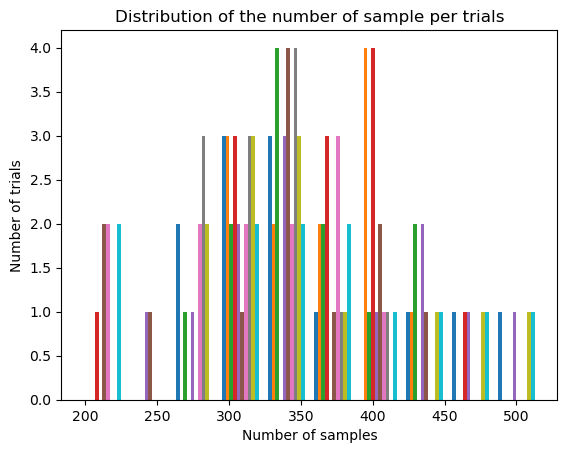

In [5]:
plt.figure()
plt.hist(number_of_samples_per_trial)
plt.xlabel("Number of samples")
plt.ylabel("Number of trials")
plt.title("Distribution of the number of sample per trials")
plt.show()

#### Visualize each channel

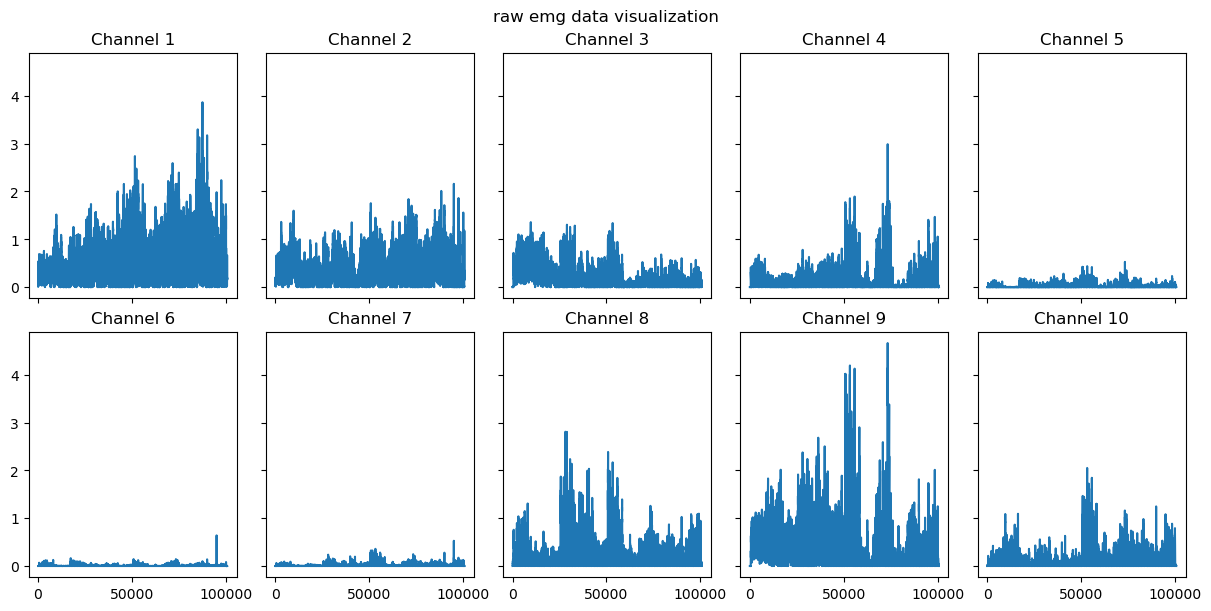

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True,sharex=True, sharey=True)
ax = ax.ravel()
    
# 10 EMG channels
number_of_emg_channels = emg.shape[-1]

for channel_idx in range(number_of_emg_channels):
        ax[channel_idx].plot(emg[:, channel_idx]) 
        ax[channel_idx].set_title(f"Channel {channel_idx + 1}")

plt.suptitle("raw emg data visualization")
plt.show()

Channel 5, 6 and 7 doesn't look to catch a lot of information. We will verify it later

#### Cut the data into trials and compute envelopes

In [7]:
# Defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], 
                                                                mov_mean_weights, axis=0)

#### Visualize all channels for one trials of each stimuli

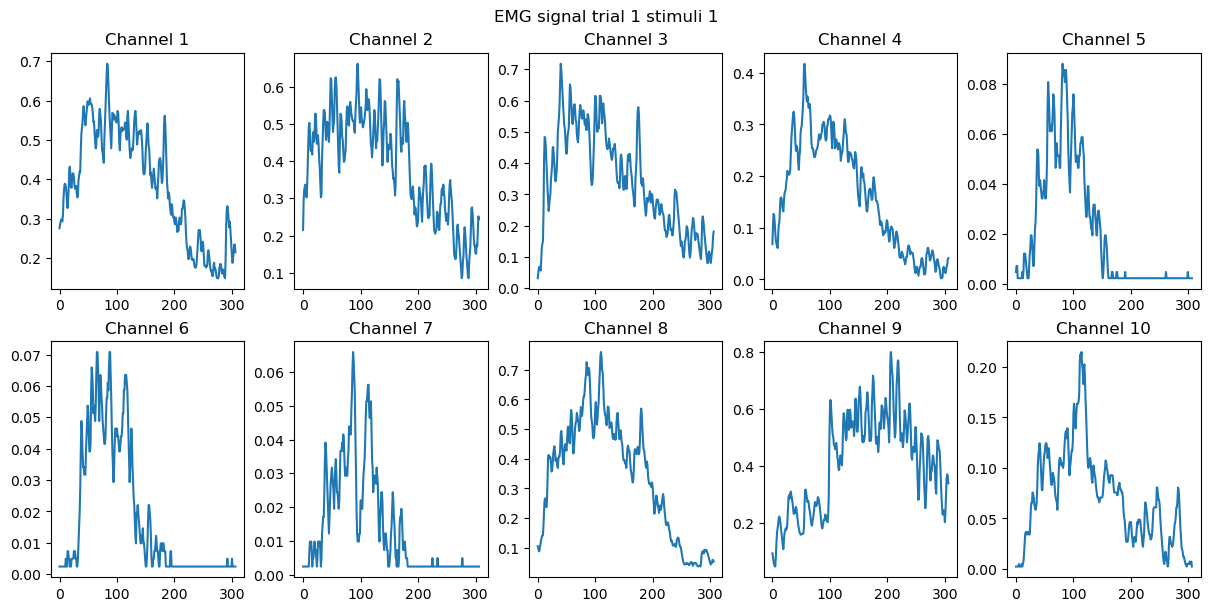

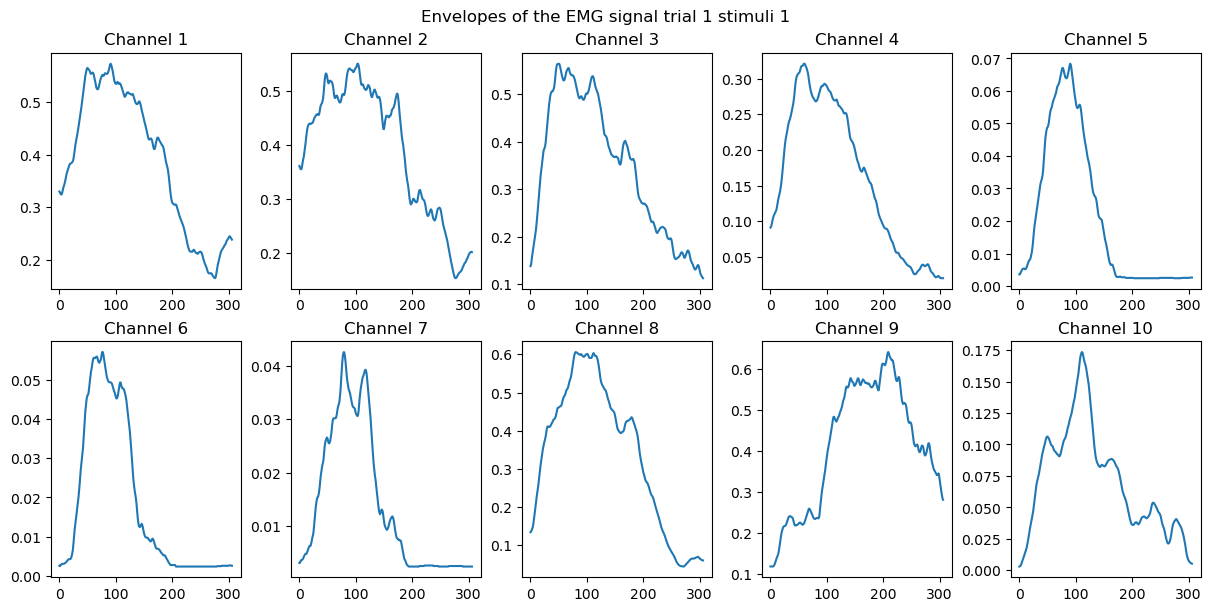

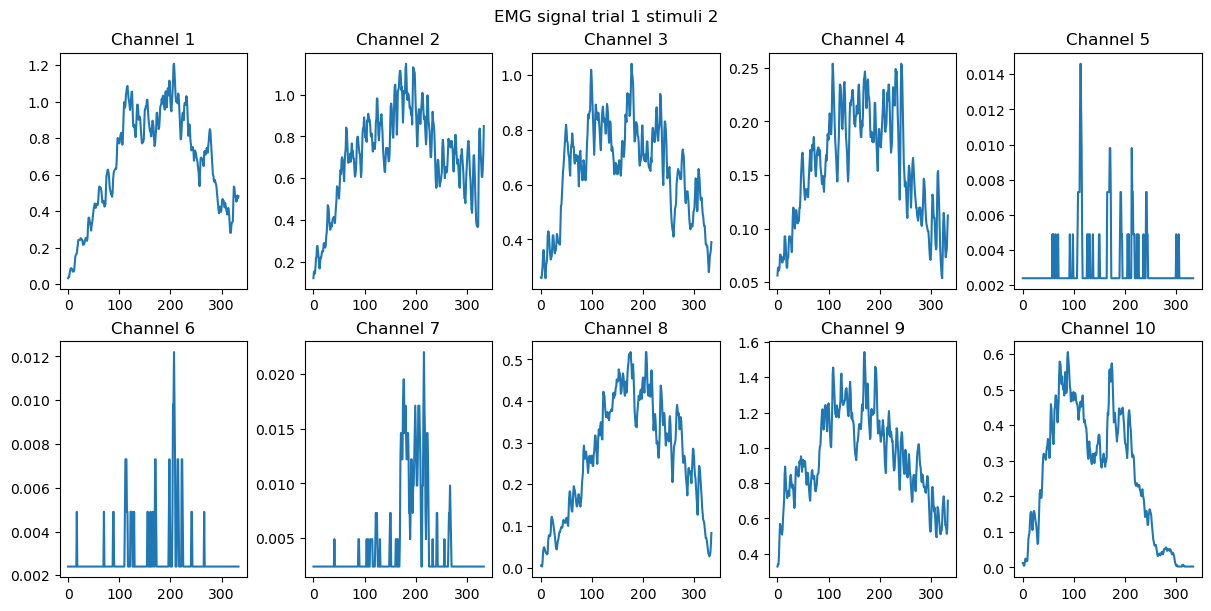

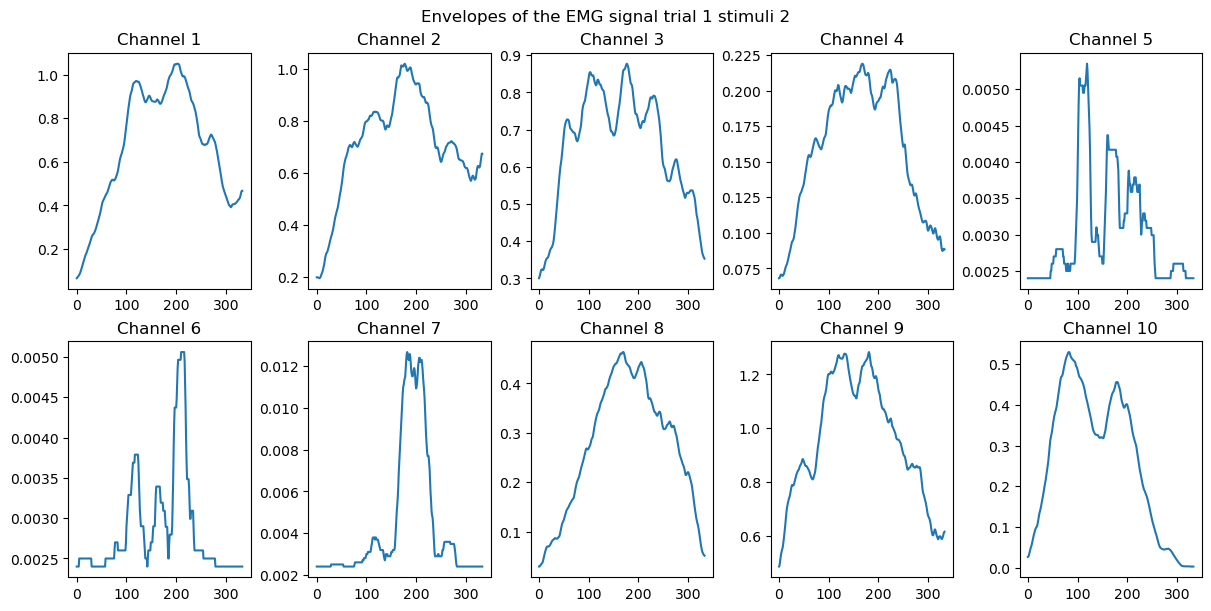

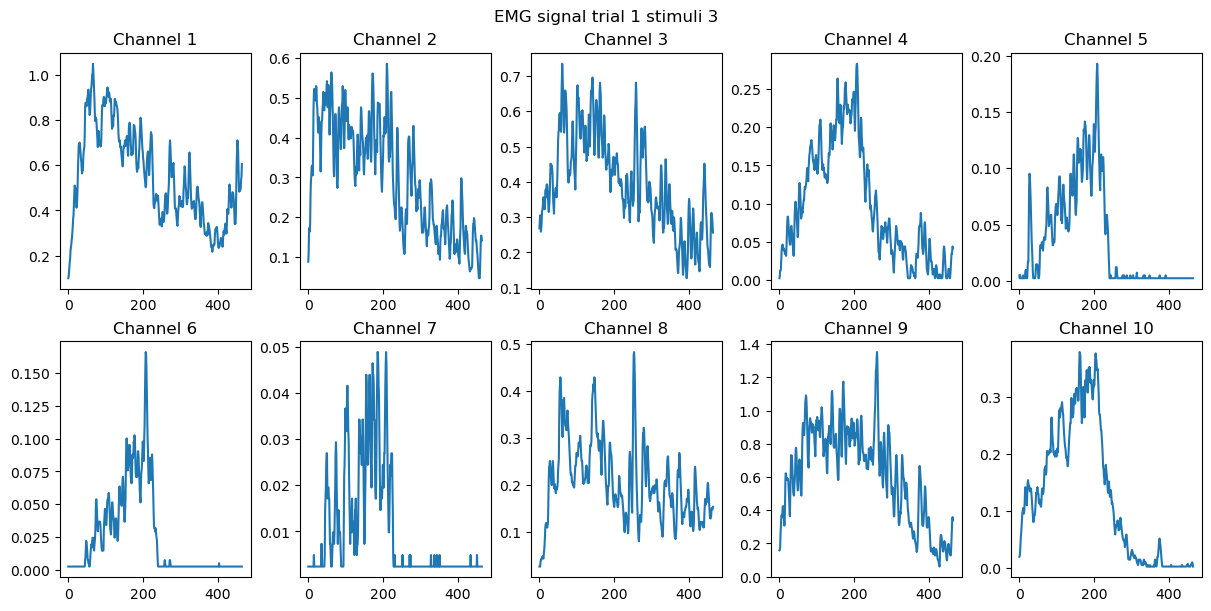

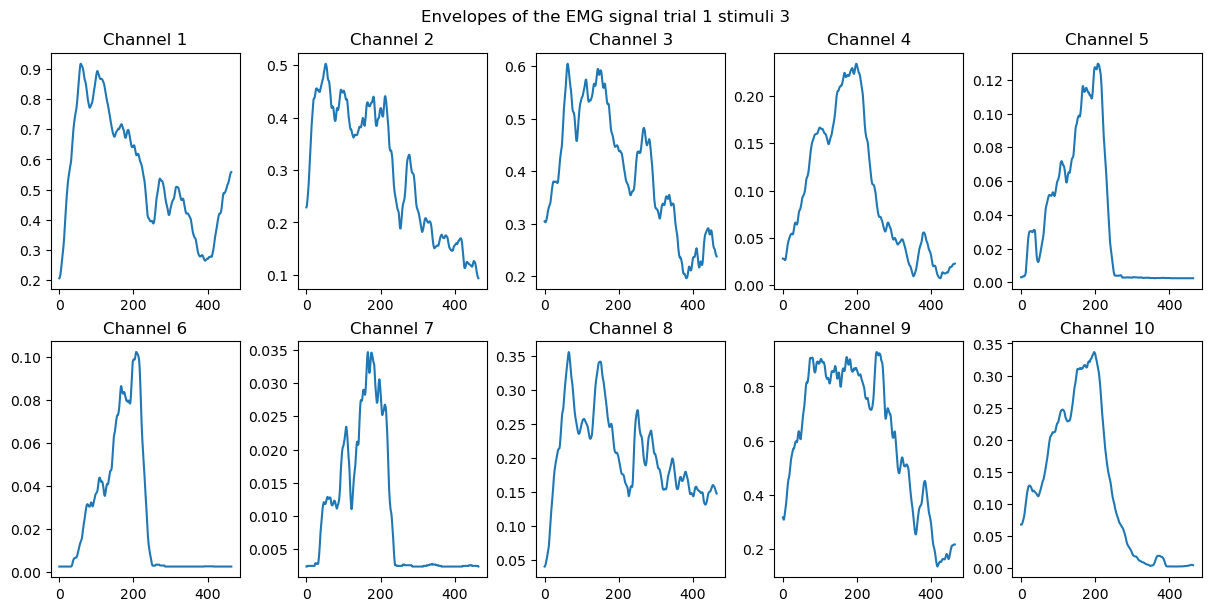

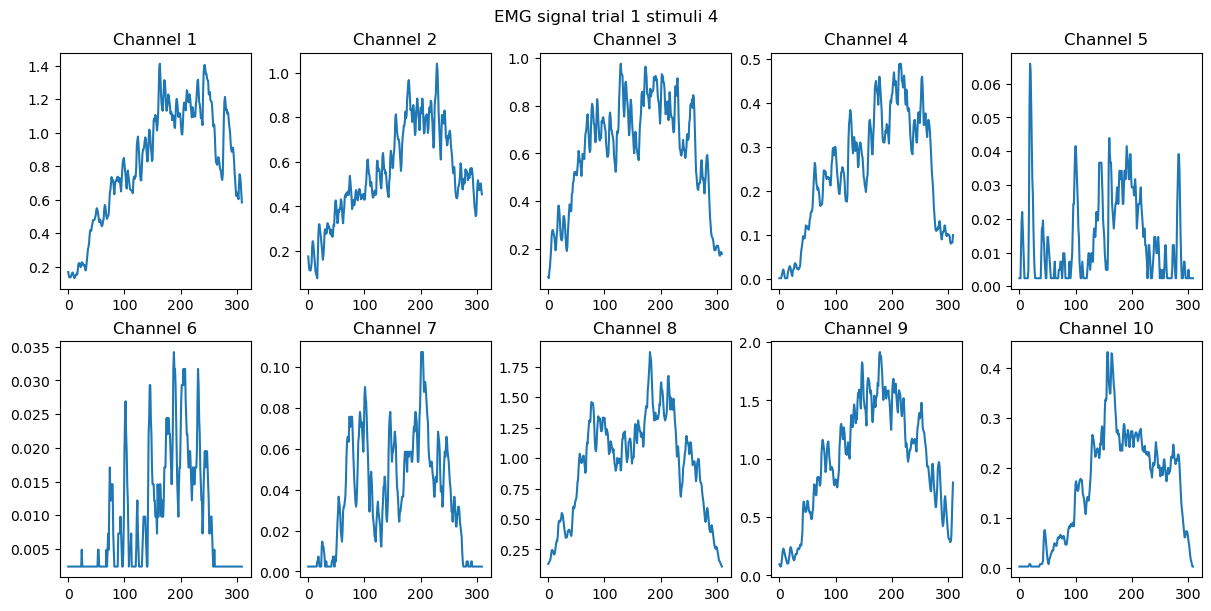

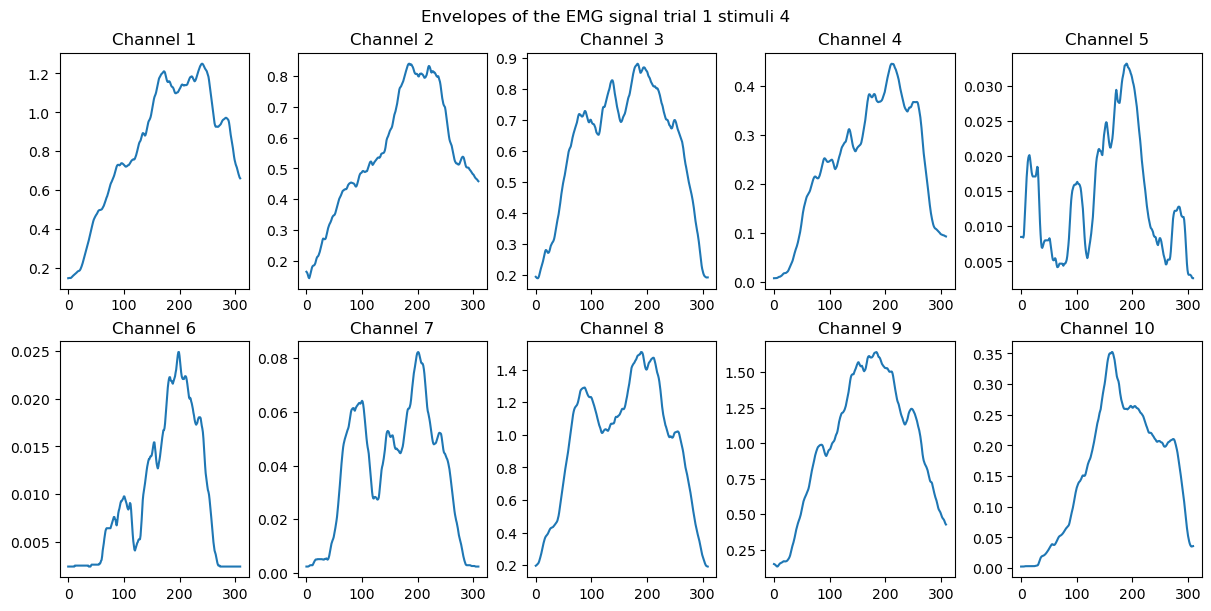

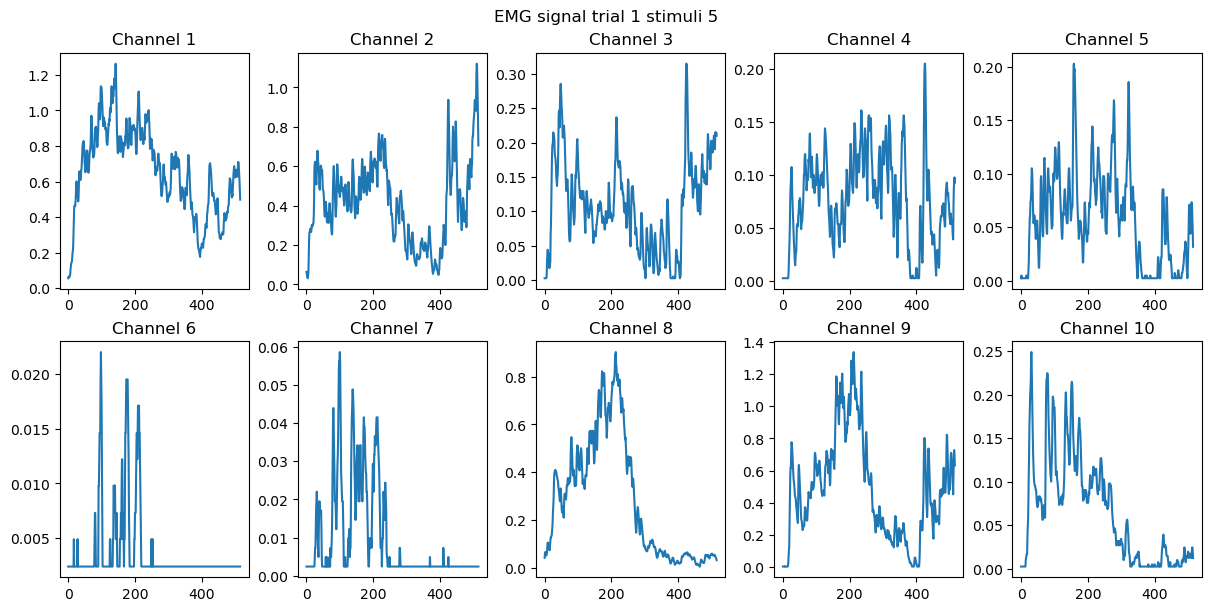

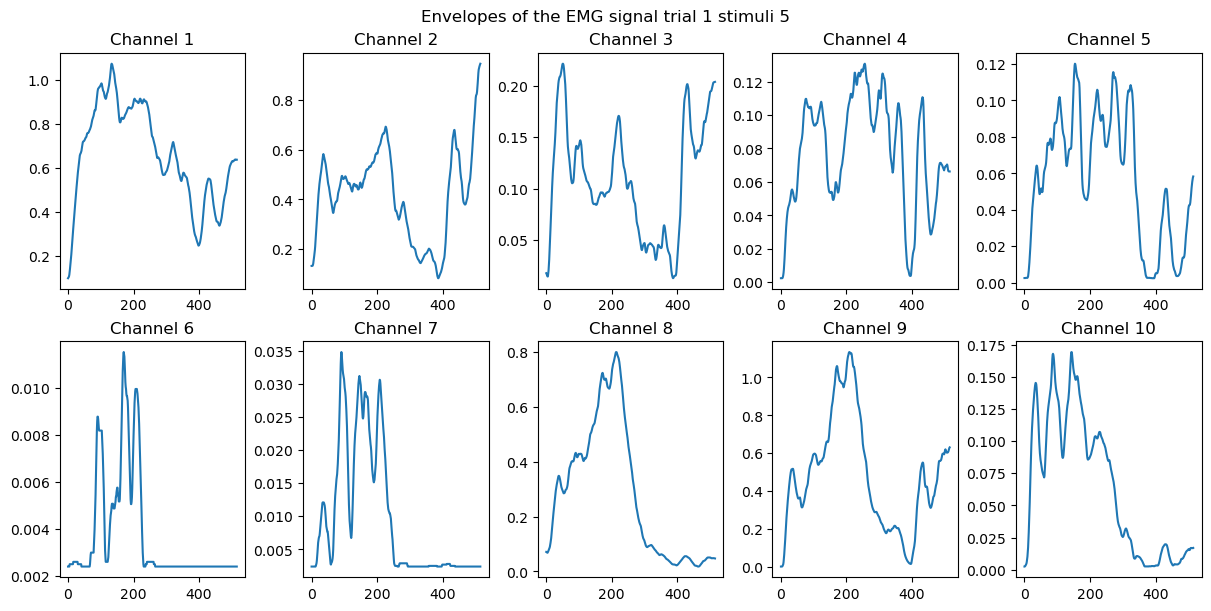

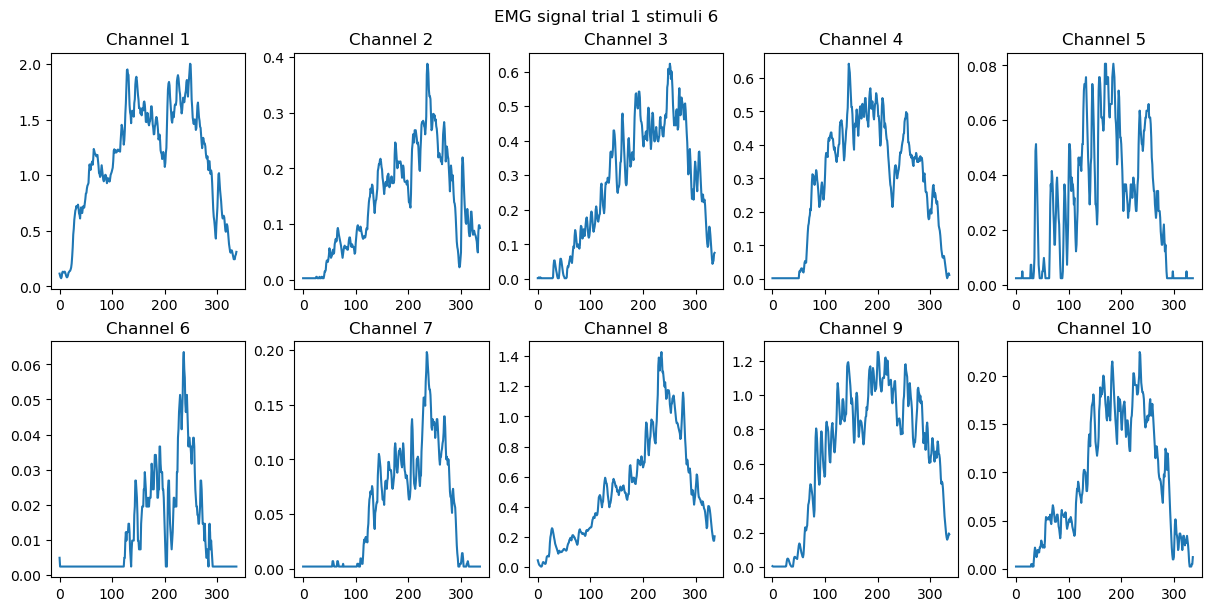

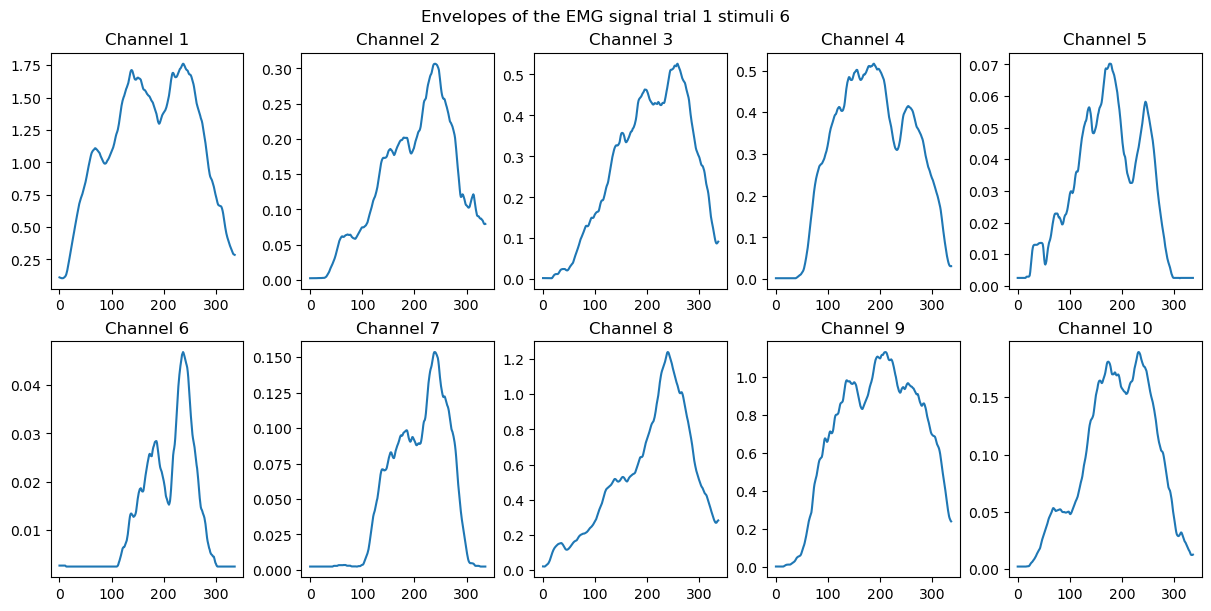

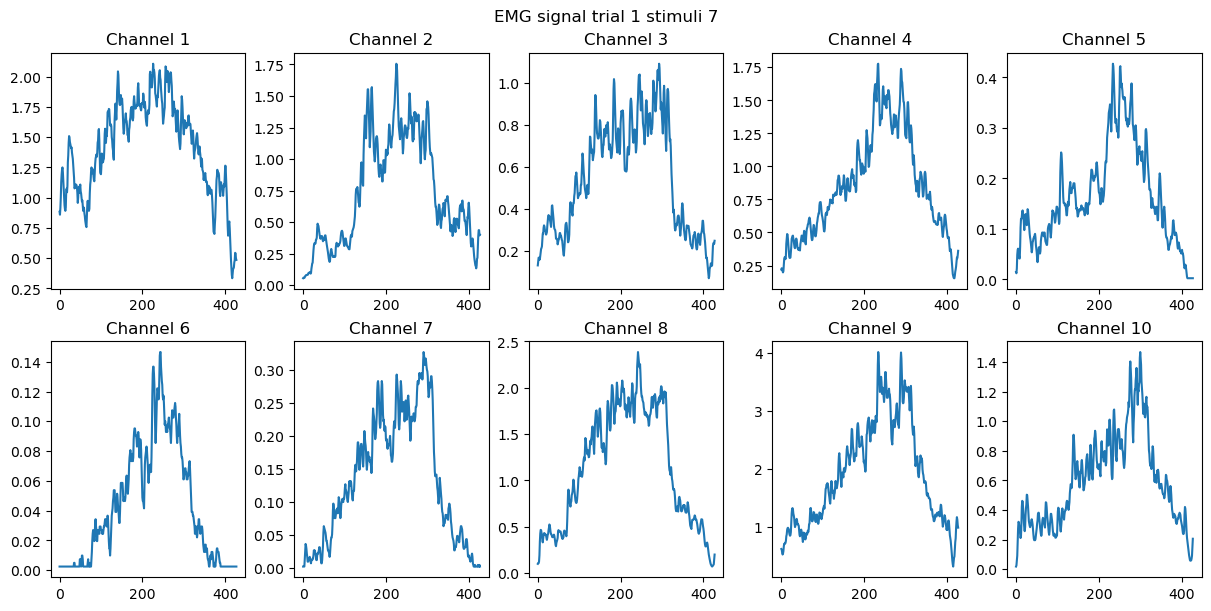

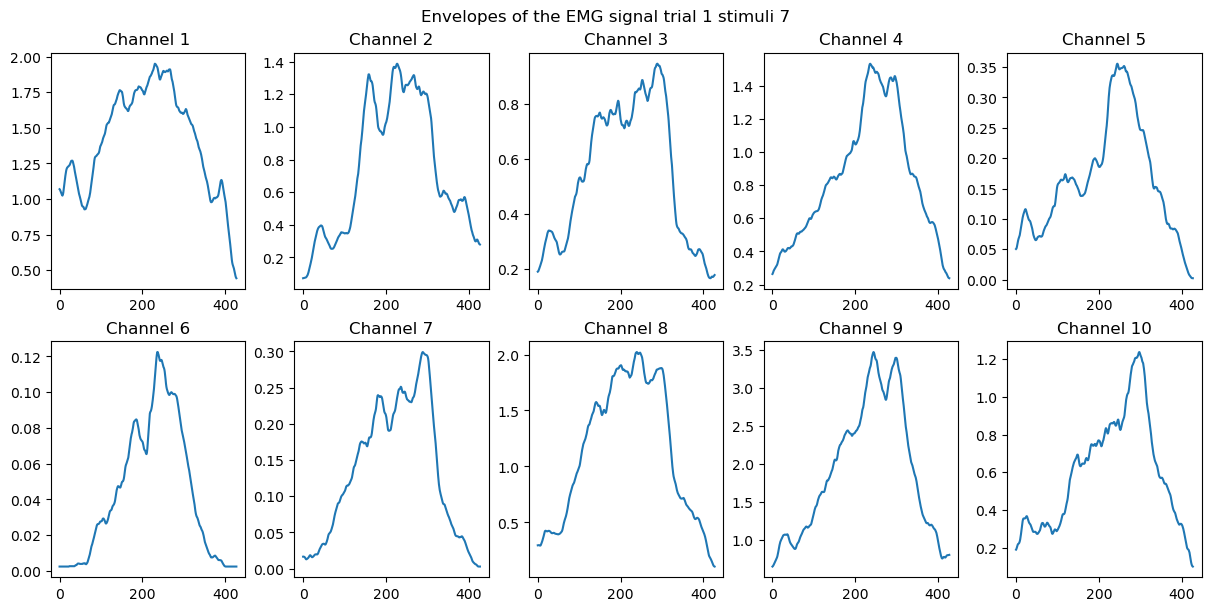

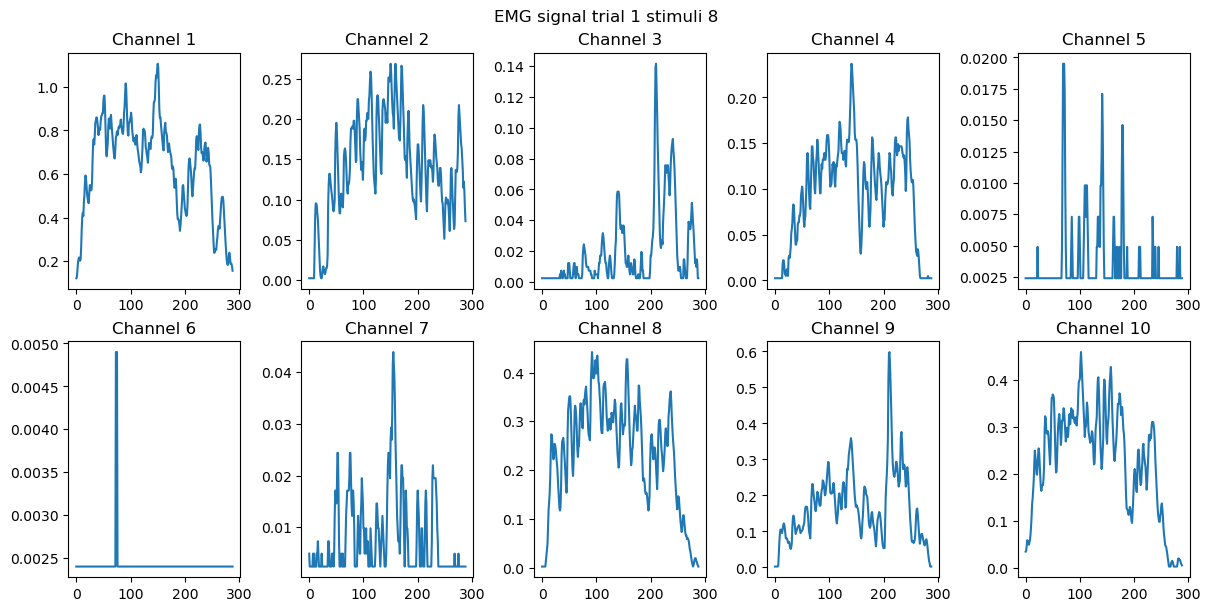

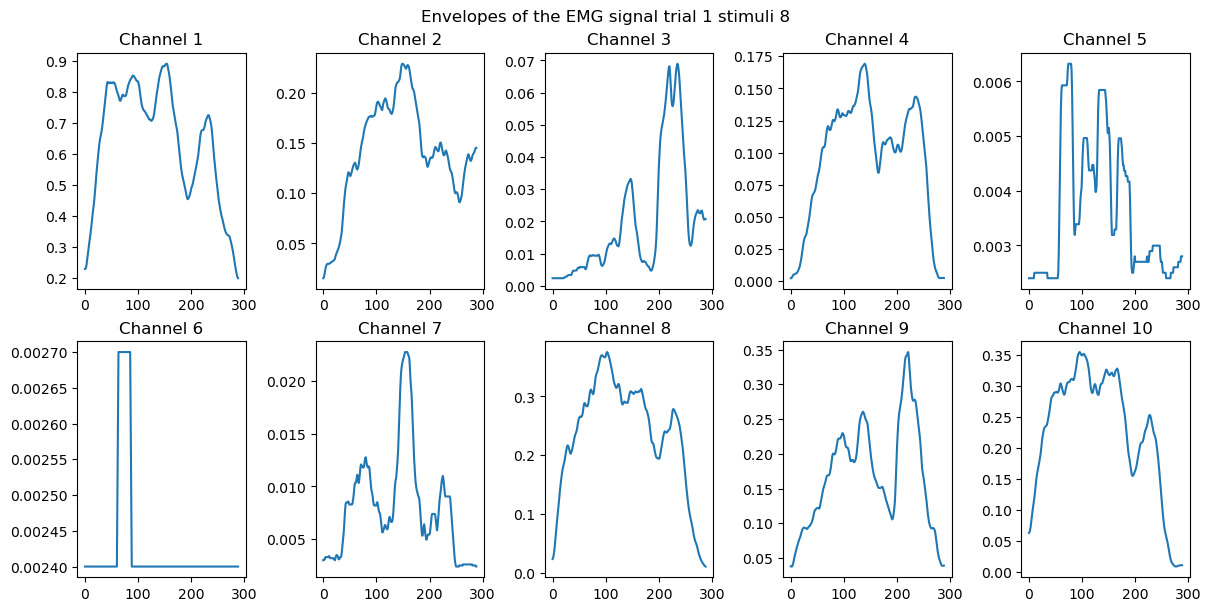

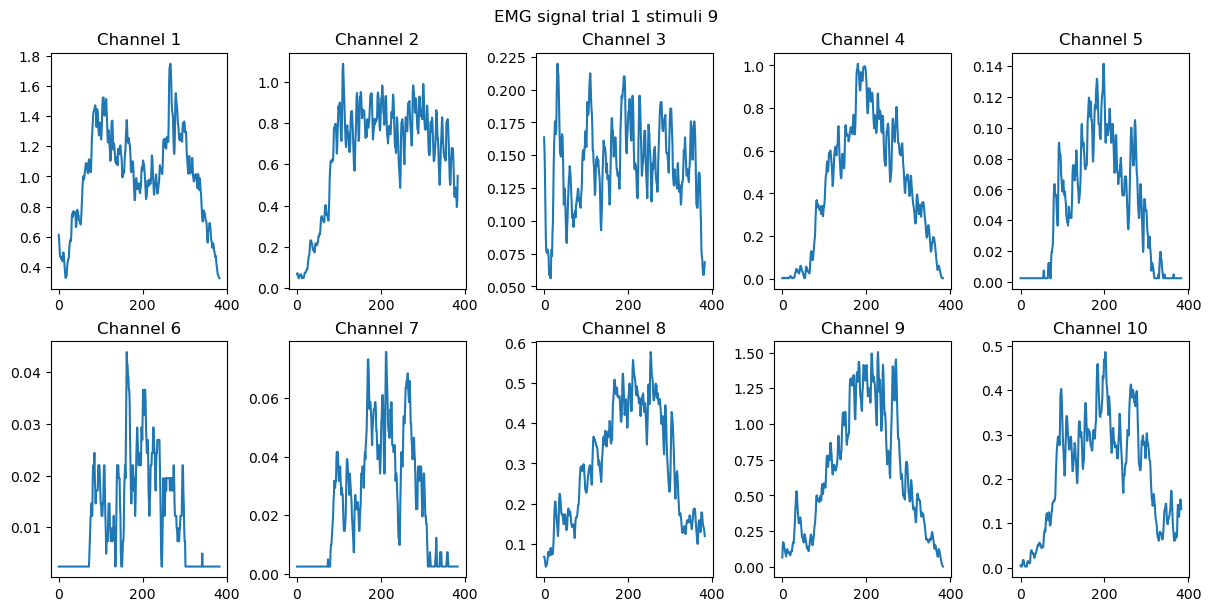

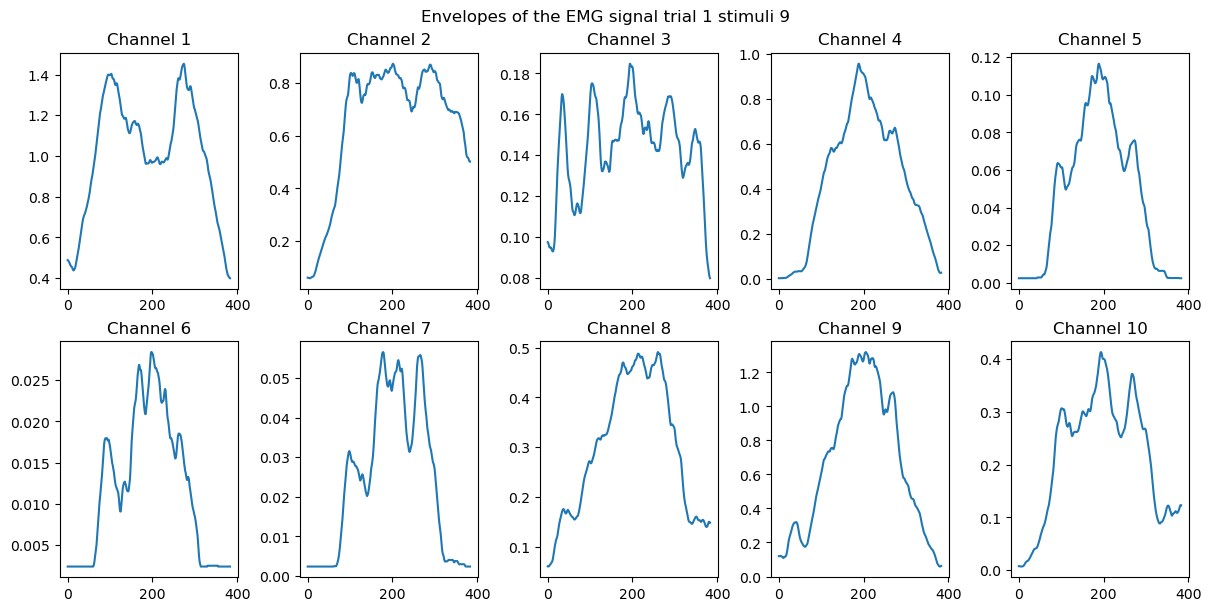

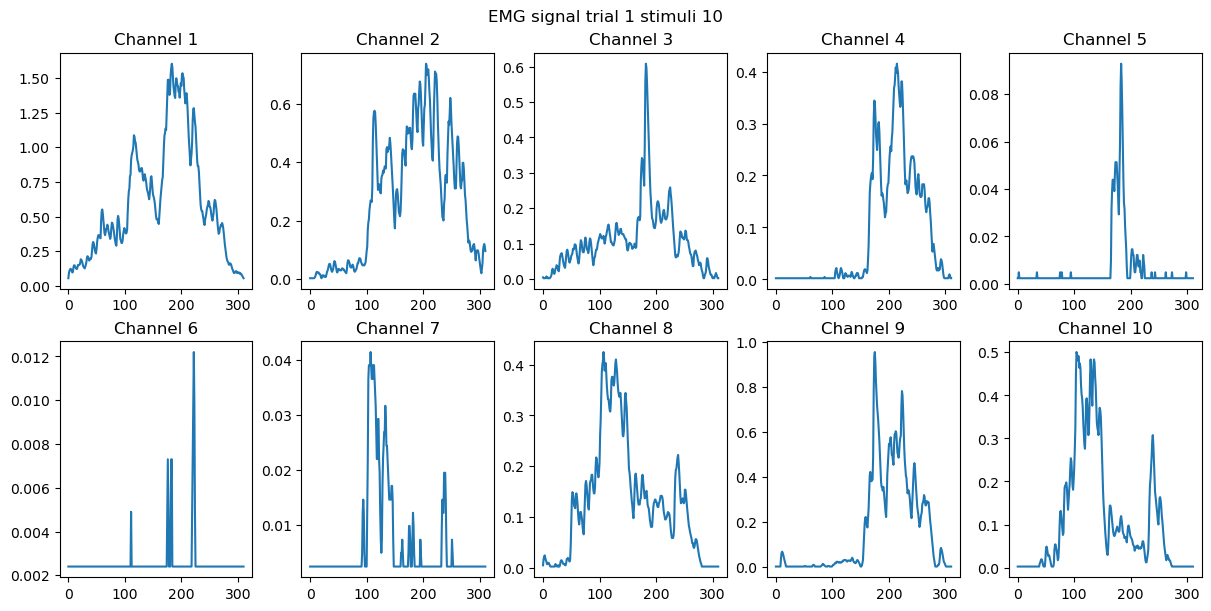

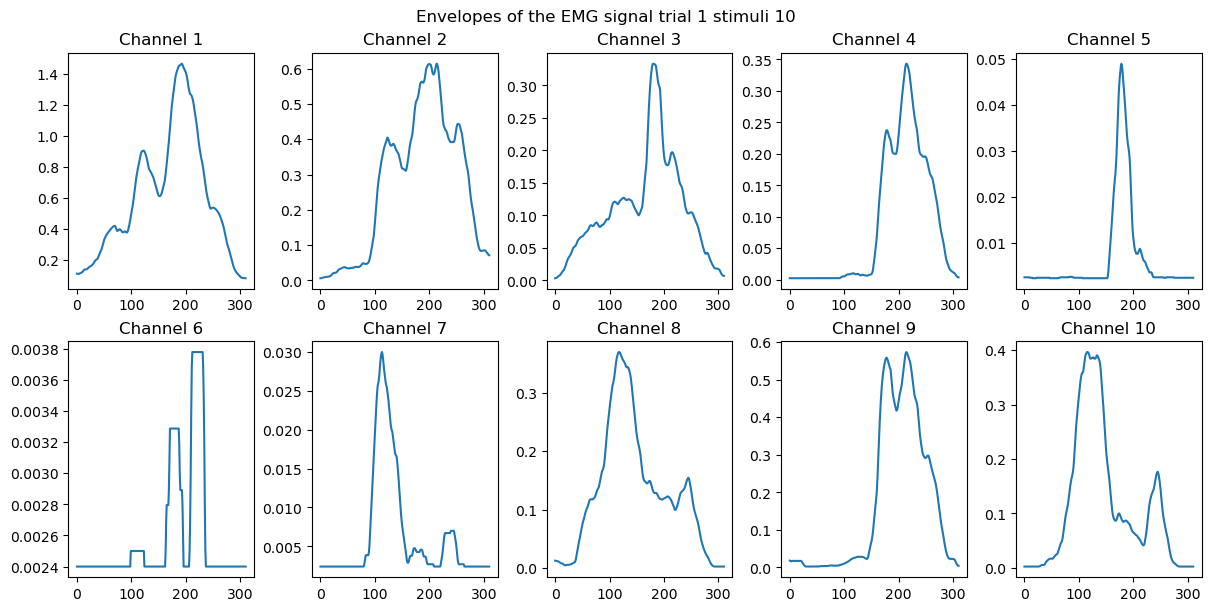

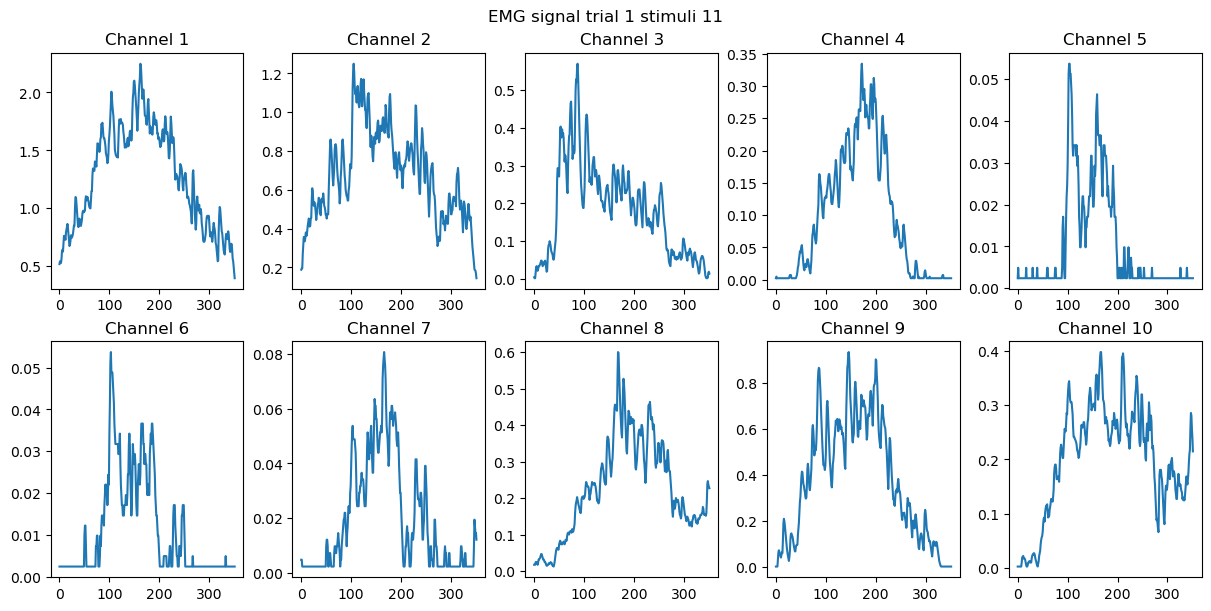

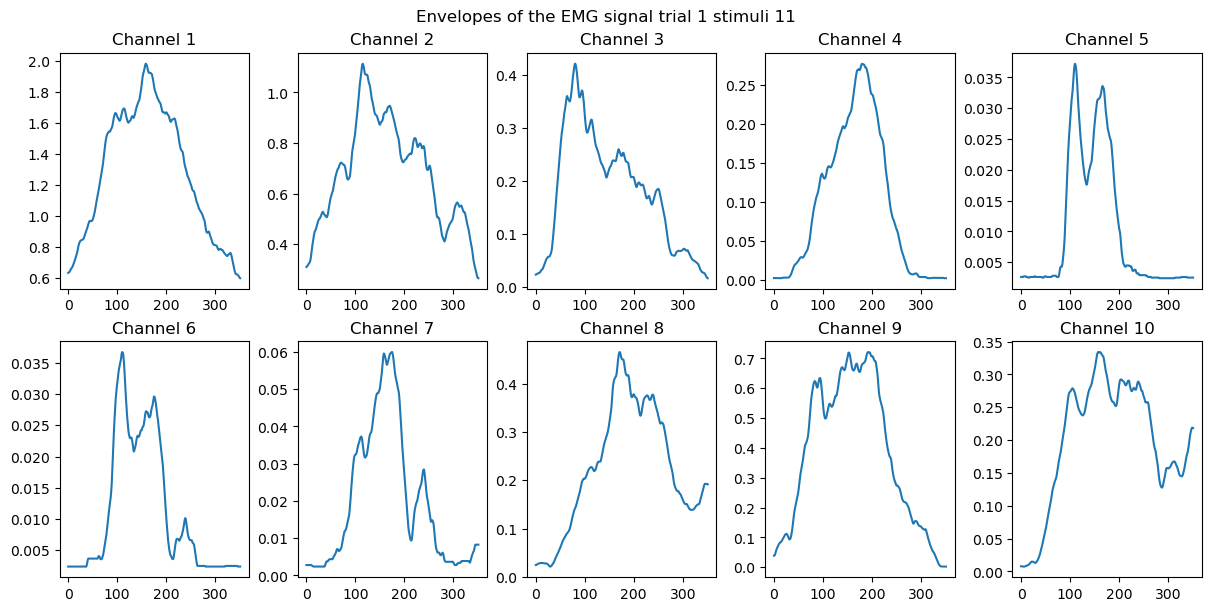

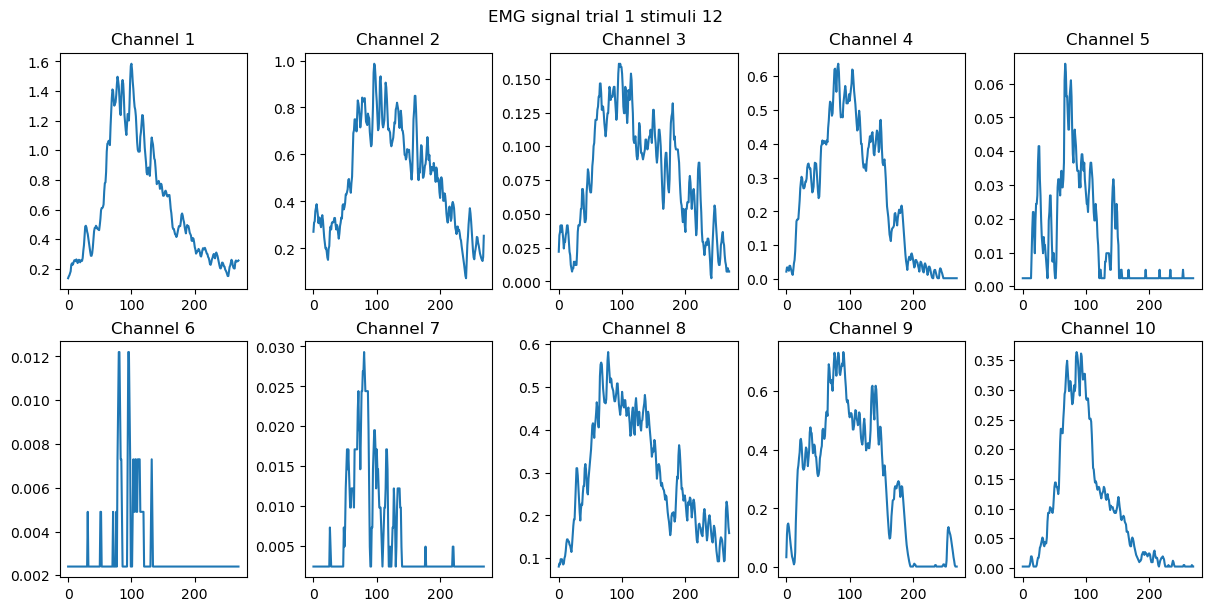

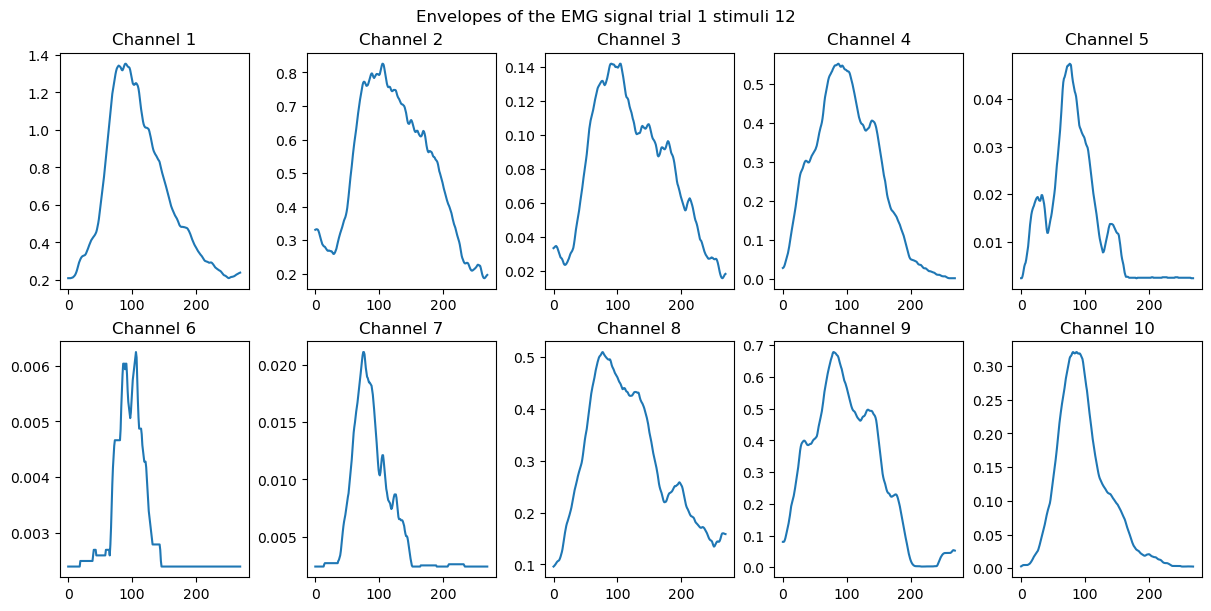

In [8]:
for stimuli in range(n_stimuli) :
# Plot EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    ax = ax.ravel()
    
    # 10 EMG channels
    number_of_emg_channels = emg.shape[-1]
    
    for channel_idx in range(number_of_emg_channels):
        ax[channel_idx].plot(emg_windows[stimuli][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
    
    plt.suptitle("EMG signal trial 1 stimuli " +str(stimuli+1))
    
    # Plot Envelopes of the EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    ax = ax.ravel()
    
    for channel_idx in range(number_of_emg_channels):
        ax[channel_idx].plot(emg_envelopes[stimuli][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
    
    plt.suptitle("Envelopes of the EMG signal trial 1 stimuli " + str(stimuli +1))
    plt.show()

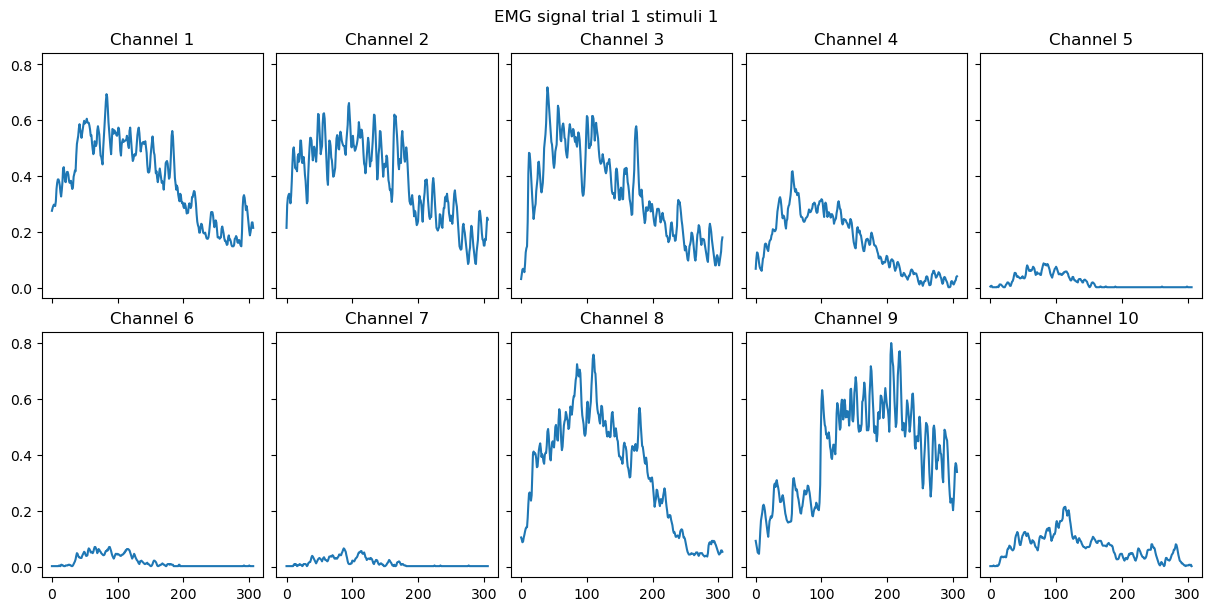

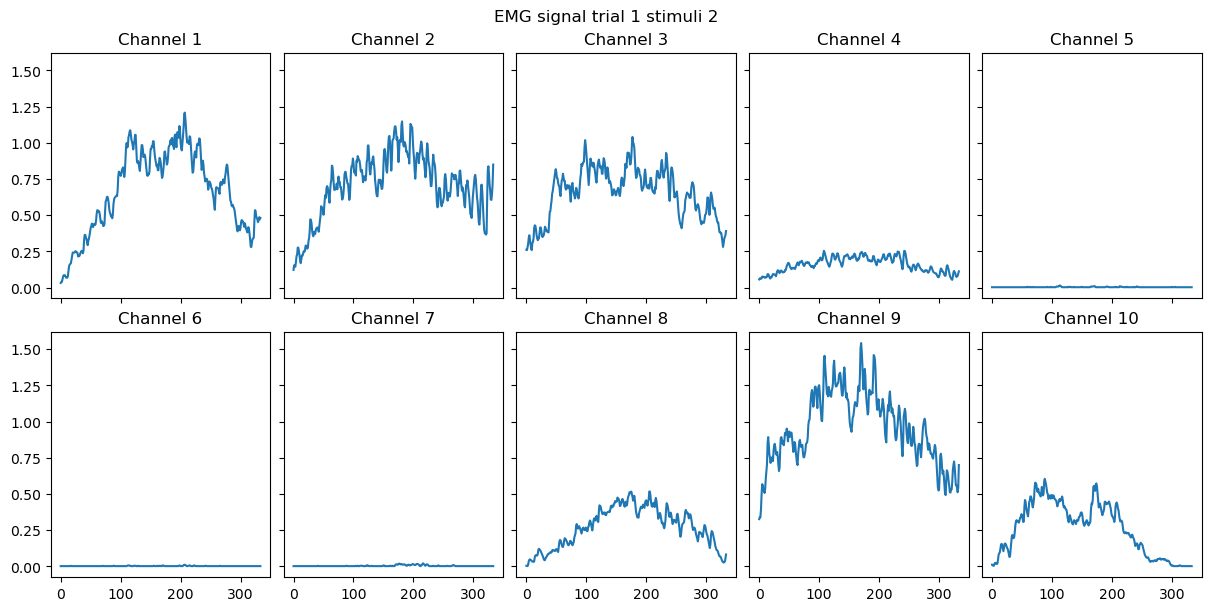

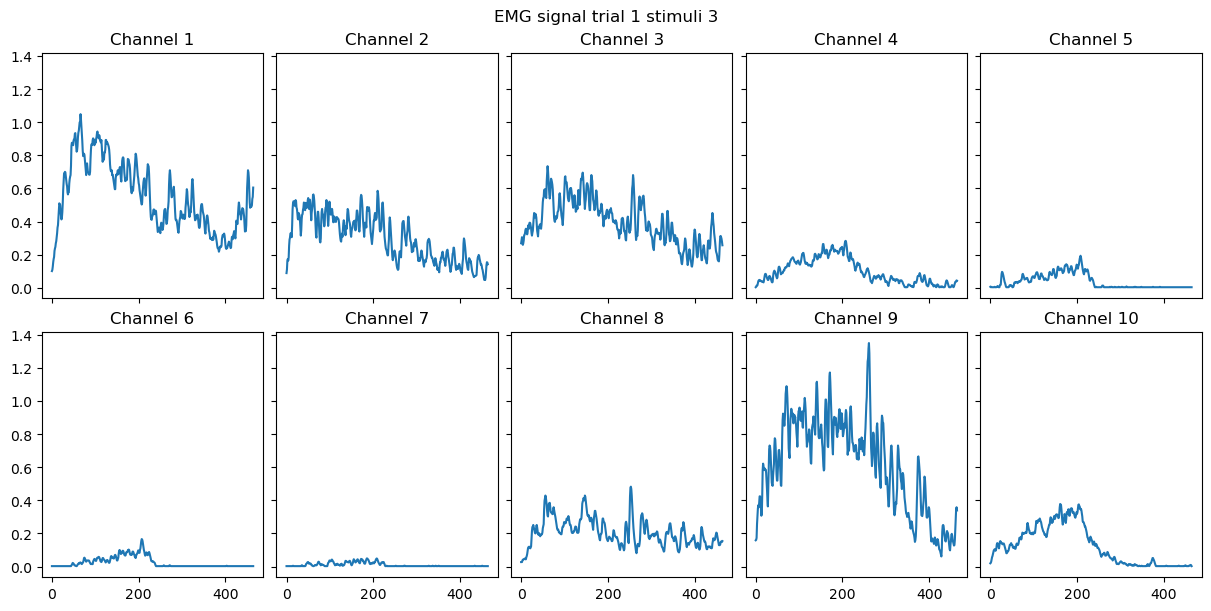

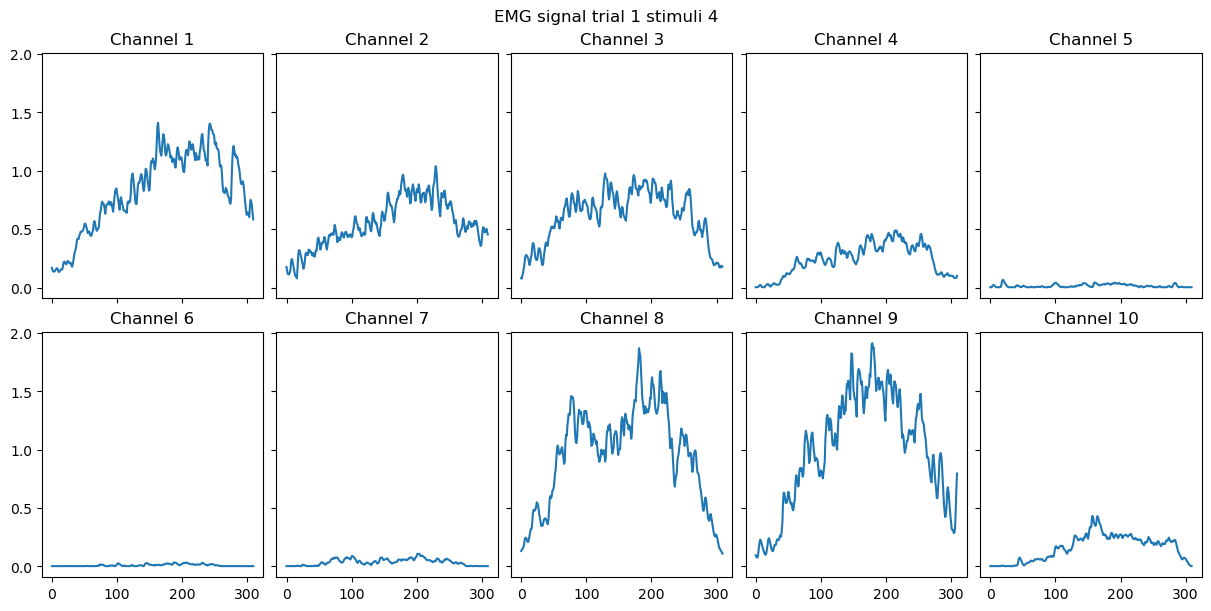

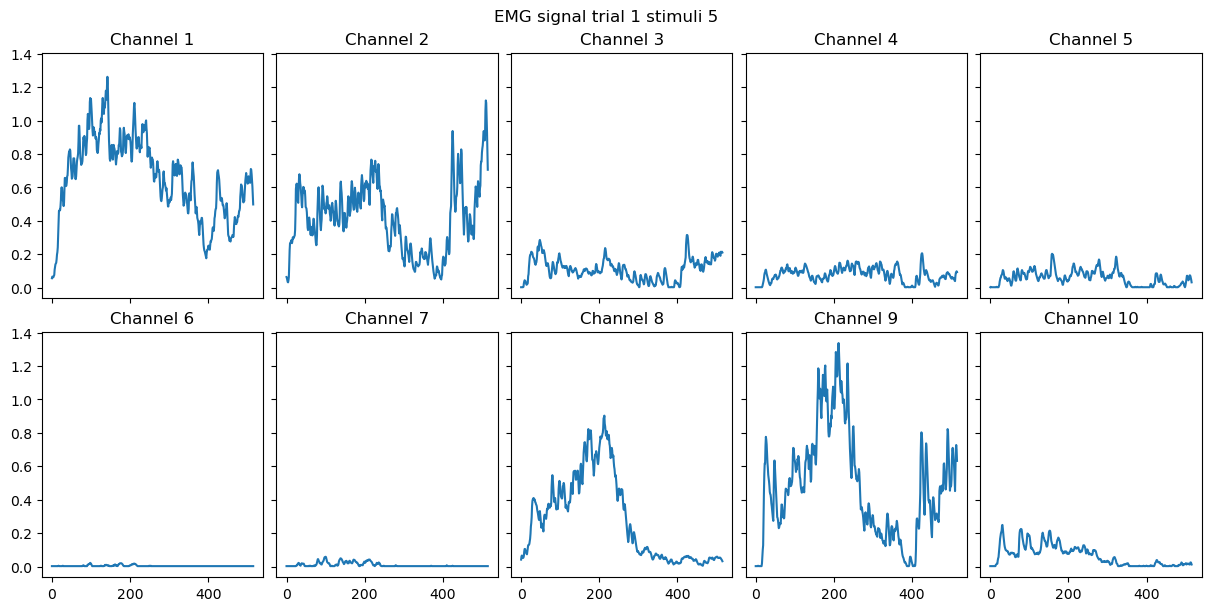

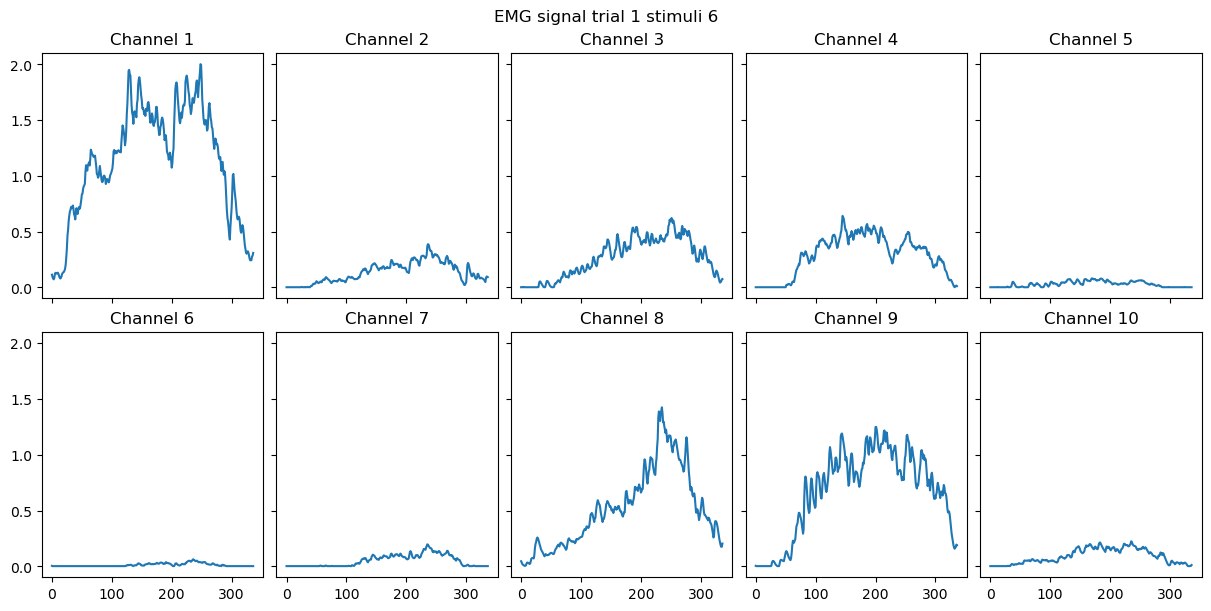

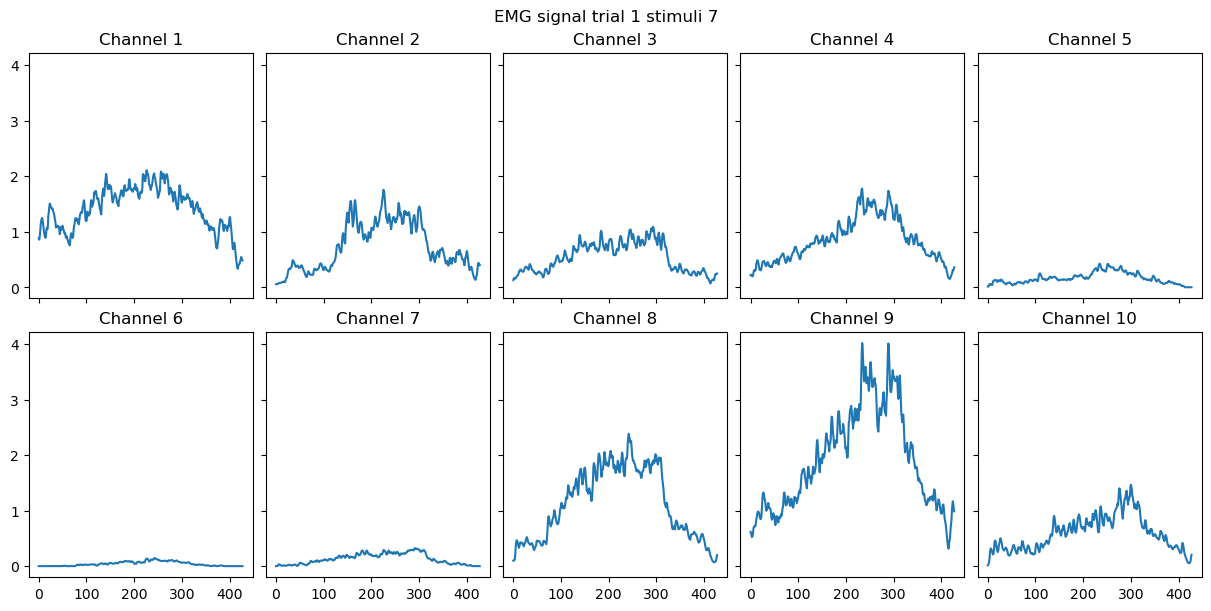

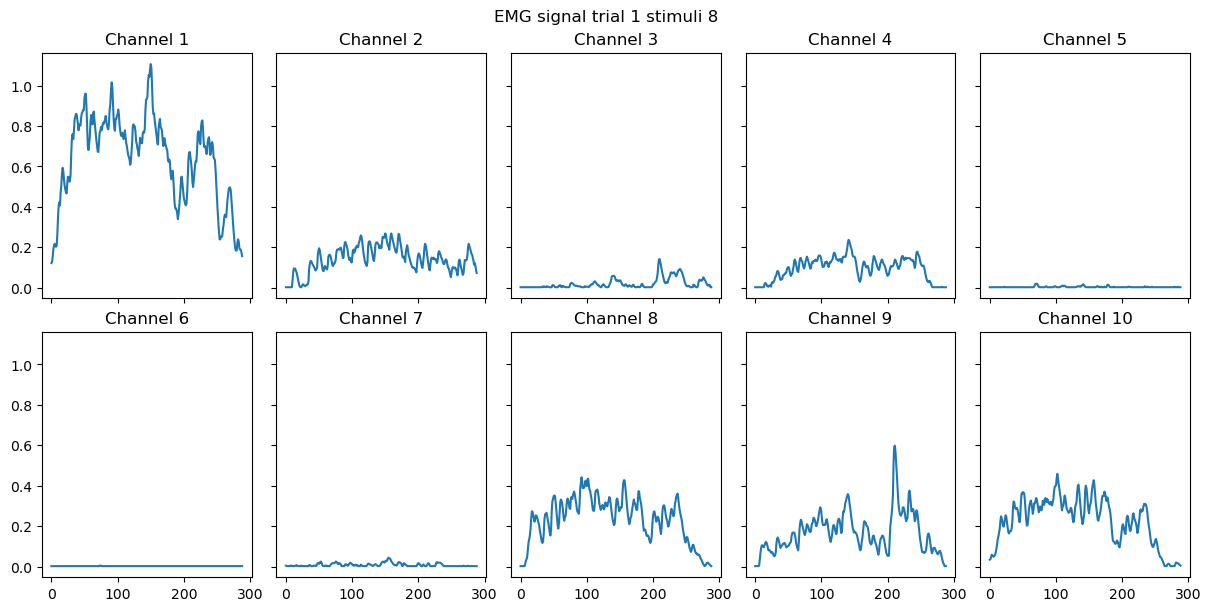

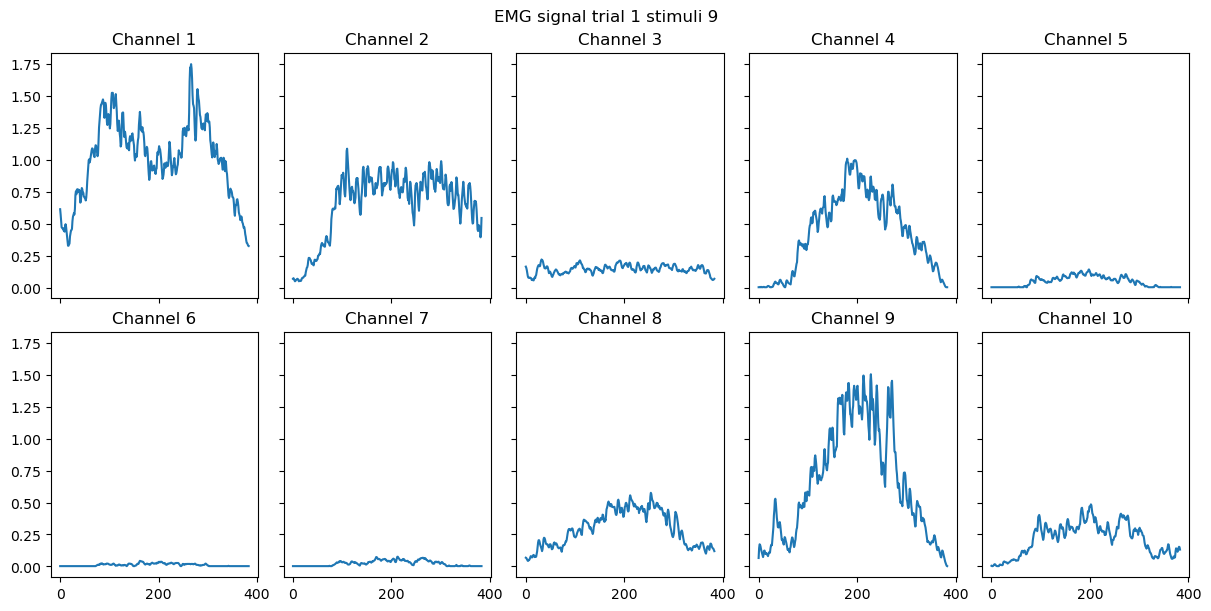

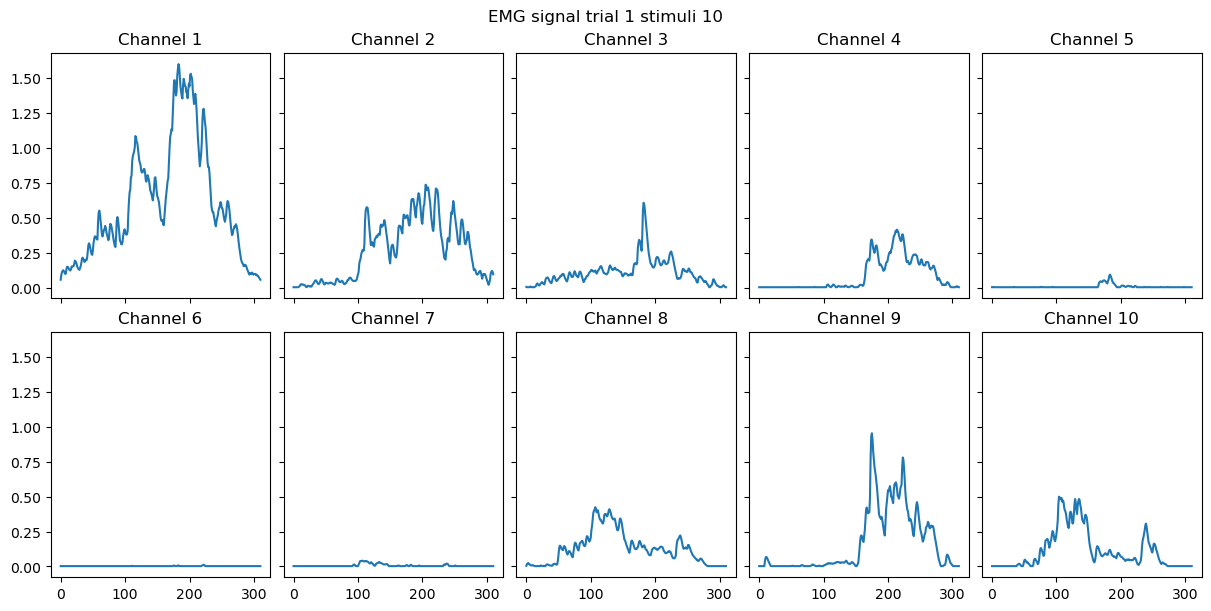

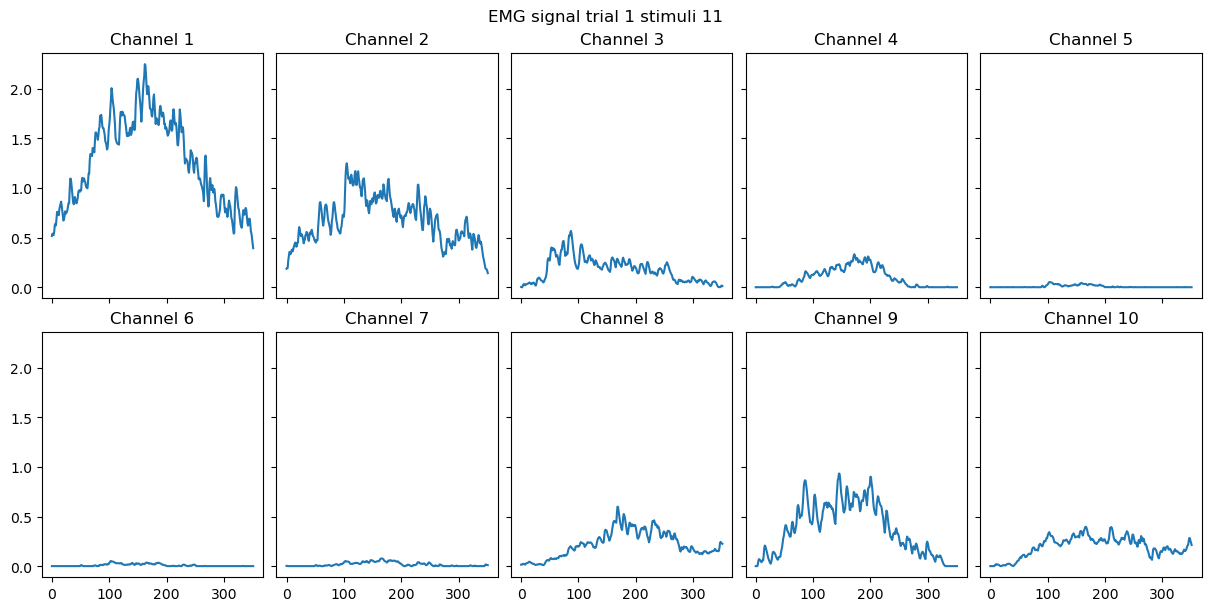

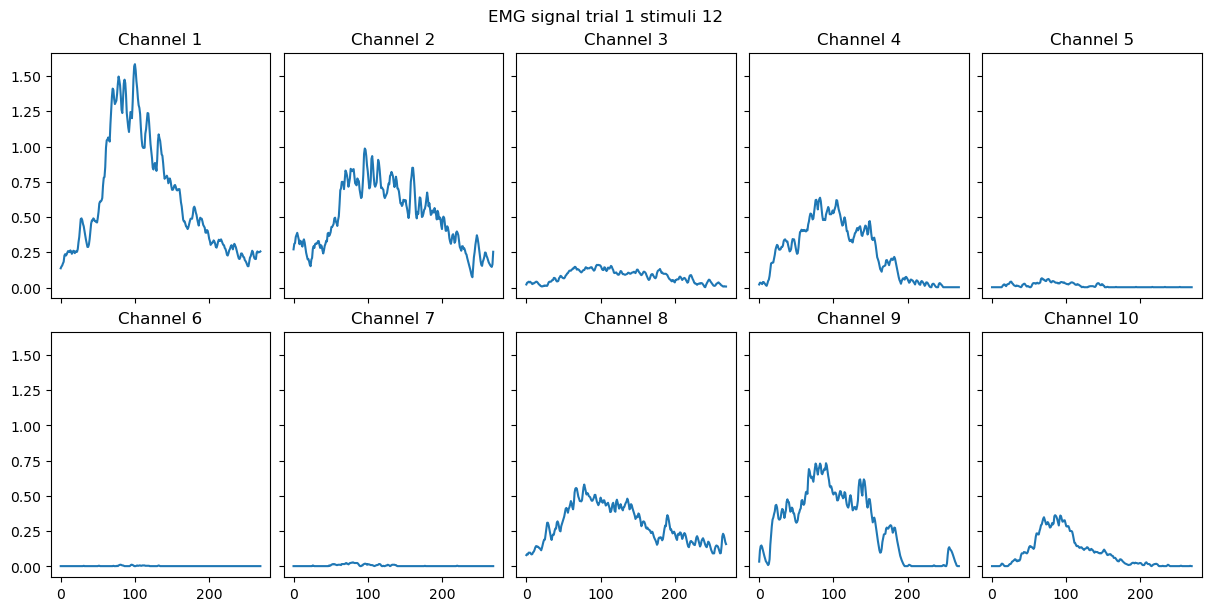

In [9]:
# Now we plot all the channels on the same y-scale

for stimuli in range(n_stimuli) :
# Plot EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    
    # 10 EMG channels
    number_of_emg_channels = emg.shape[-1]
    
    for channel_idx in range(number_of_emg_channels):
        ax[channel_idx].plot(emg_windows[stimuli][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
    
    plt.suptitle("EMG signal trial 1 stimuli " +str(stimuli +1))
    plt.show()

We will look at the distribution of information for each trials

In [10]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

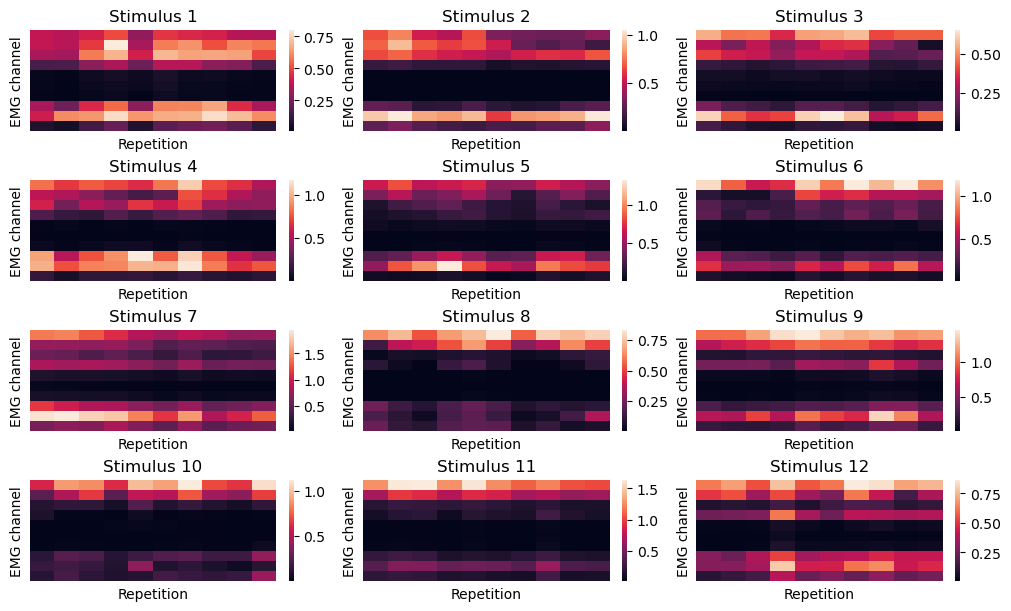

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")


plt.savefig("plot/mean_activation.png")

In fact channel 5, 6 and 7 aren't catching a lot of signal for most of the trials. We will look at trial with big values in one or more channel. 

#### look for outliers

to look for outliers, we will do 3 type of box plots :
- mean activation per channel per trials, for each stimulus : identify if one channels have an outlier value regarding the other trials for this stimulus.
- mean activation per channel per trials, in general: identify if a channel have an outlier value, independently of the stimulus. Will identify big outliers for one channels (for example, a channel catching another signal than emg or not functioning for one trials.) 
- mean, max, and min of the mean activation per channels per trials. Will identify big outliers in trials (for example, for this trials none of the channel recorded something, or all caught another signal, or there is one channel with a really high value compare to other trials.) 

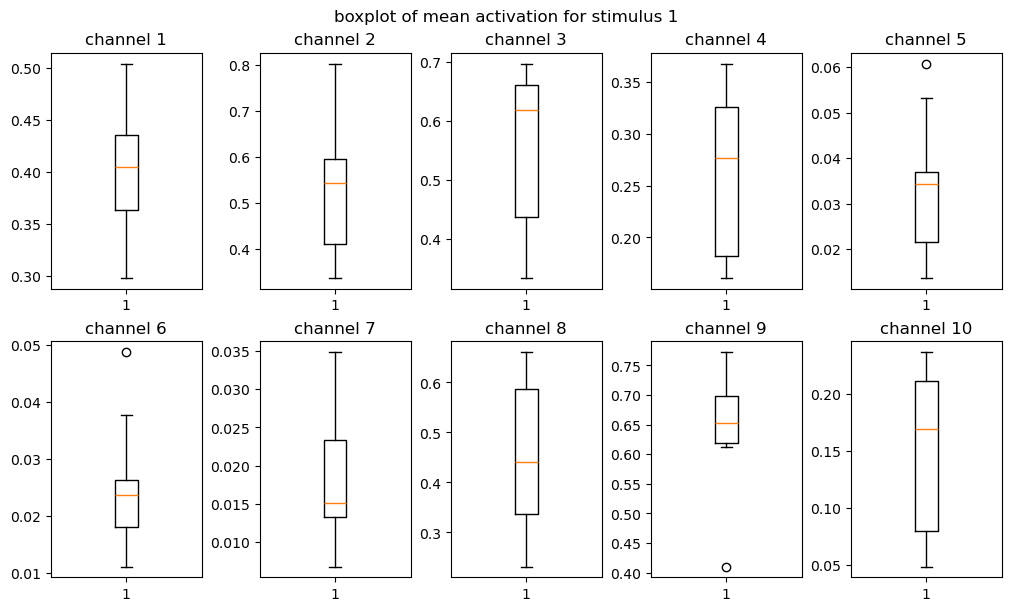

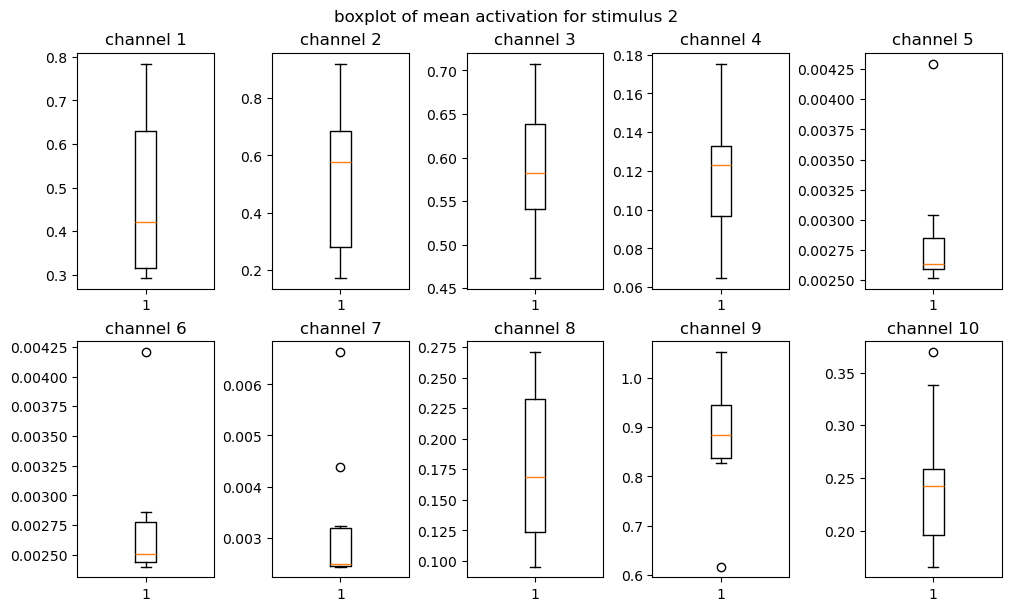

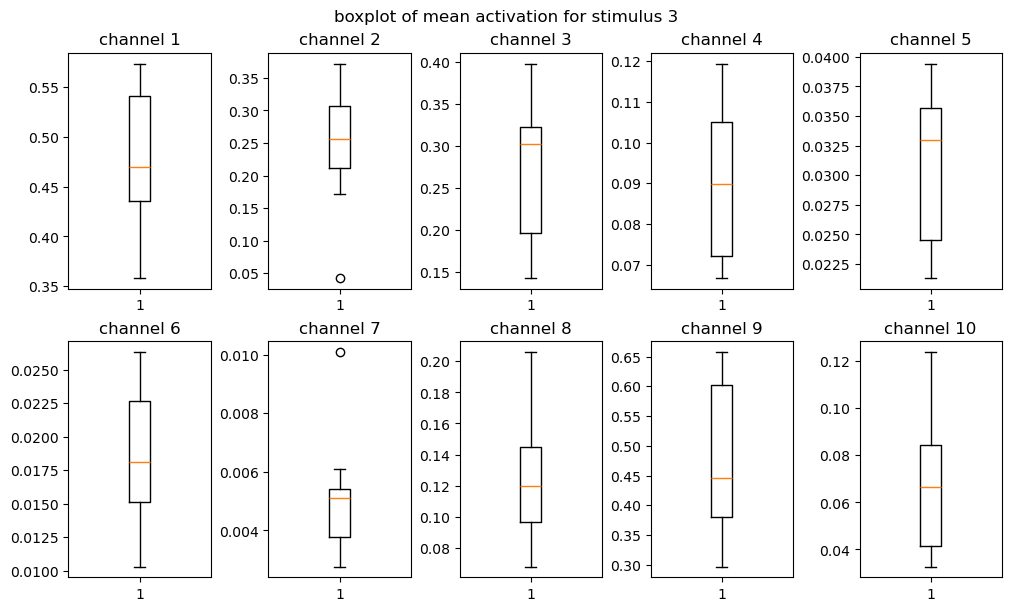

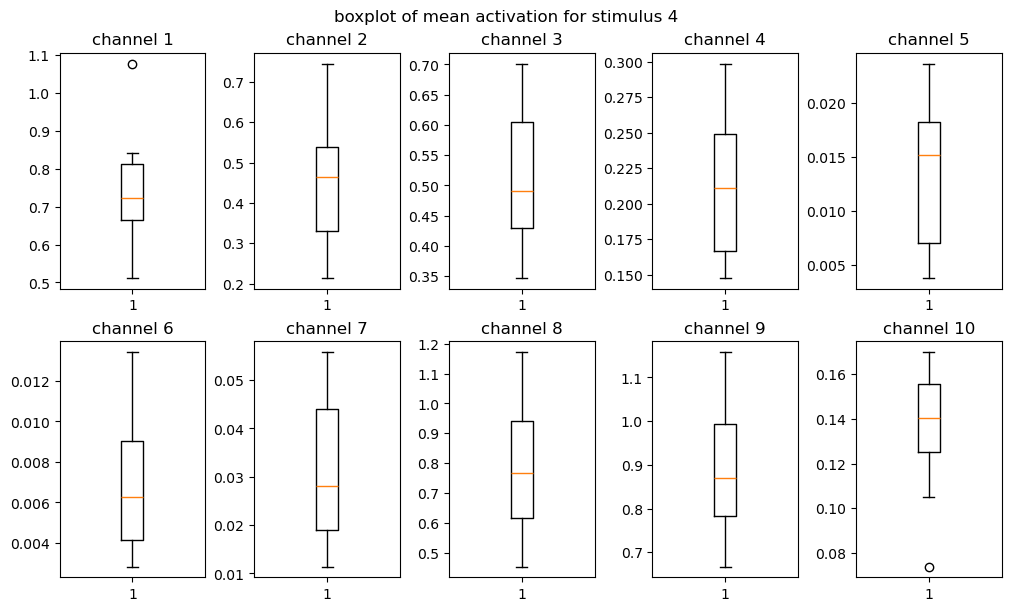

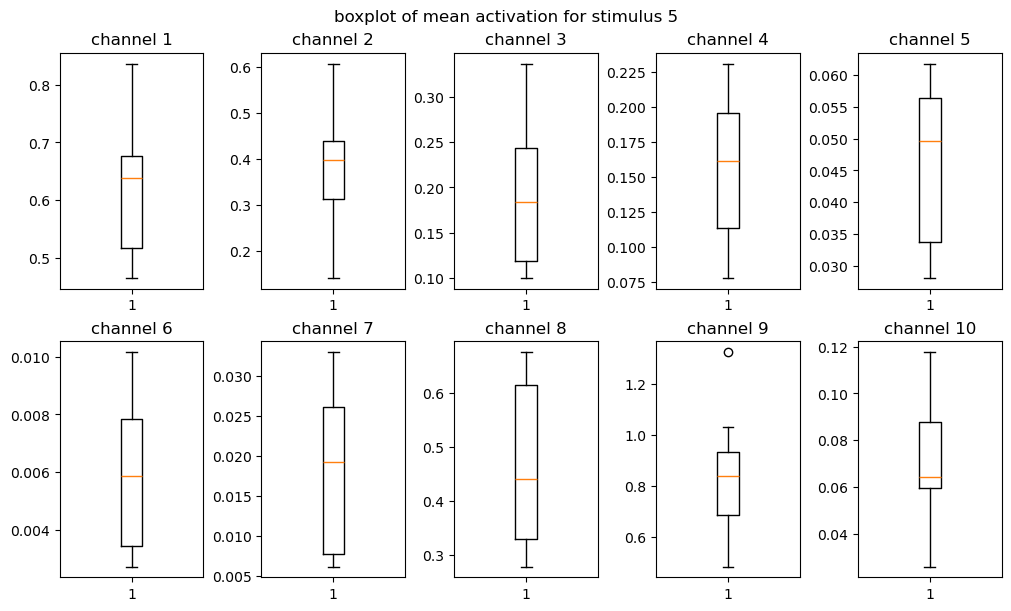

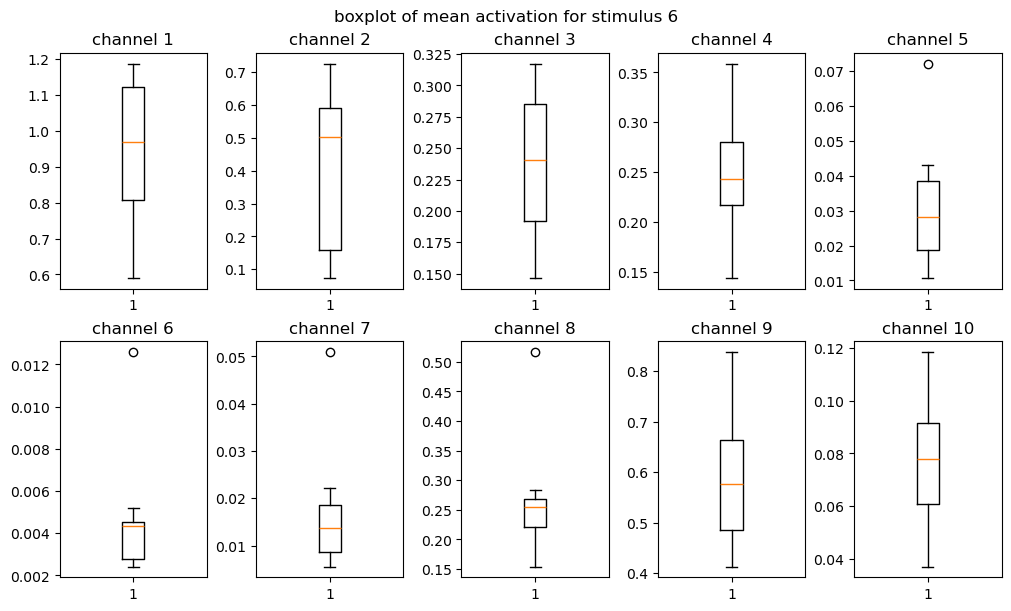

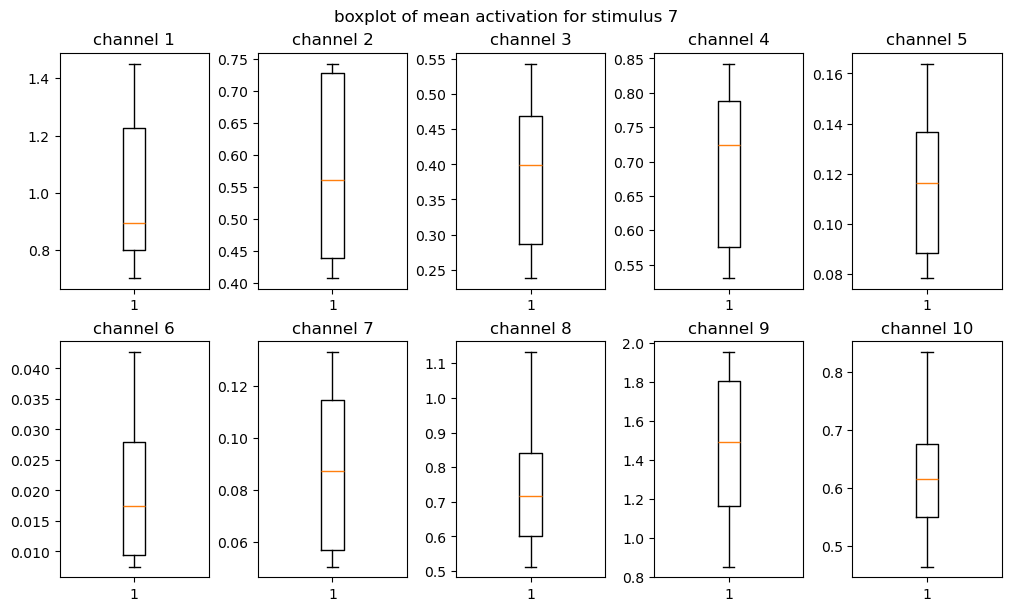

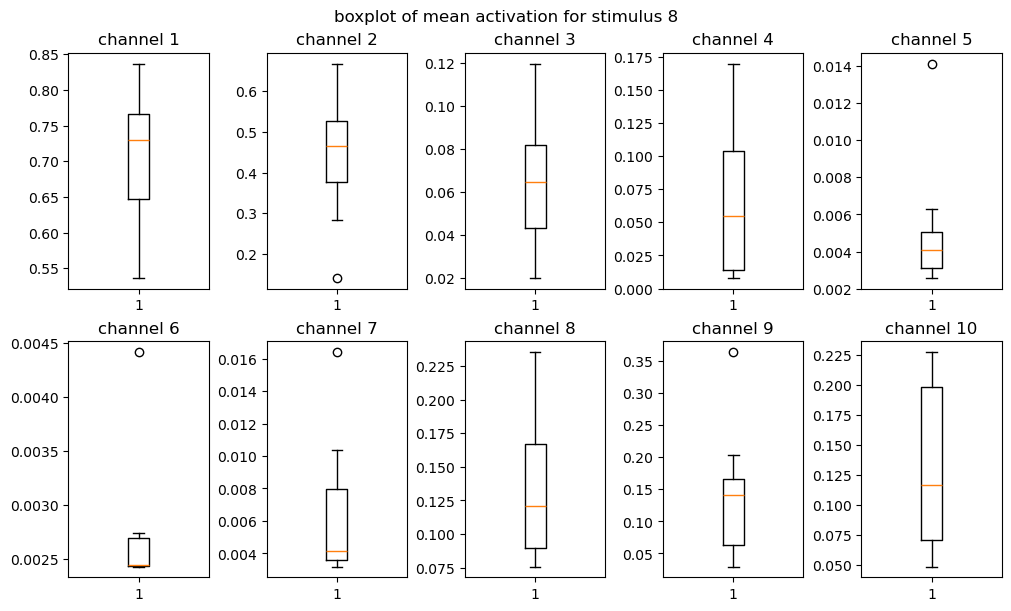

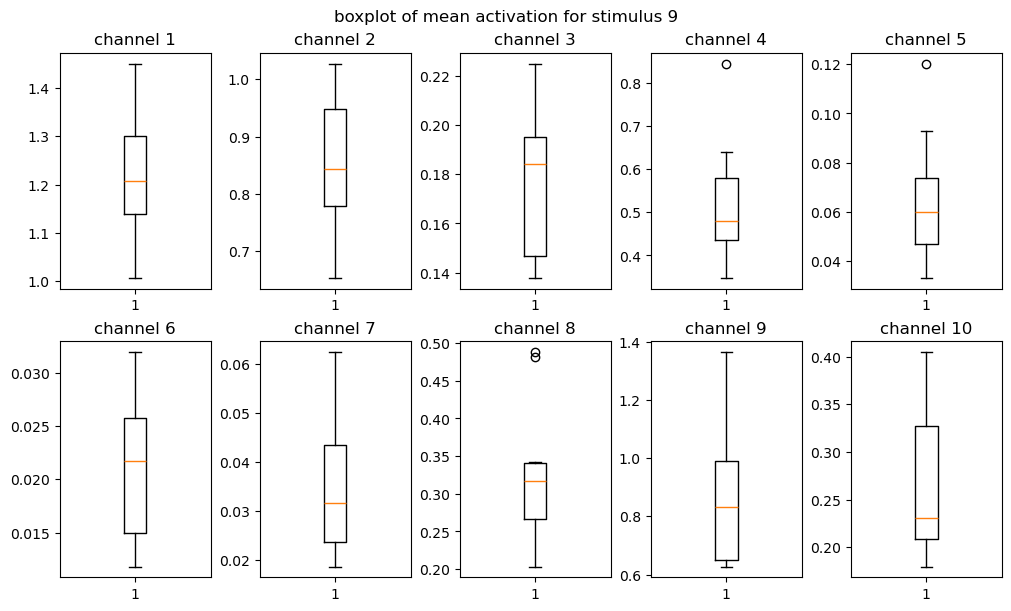

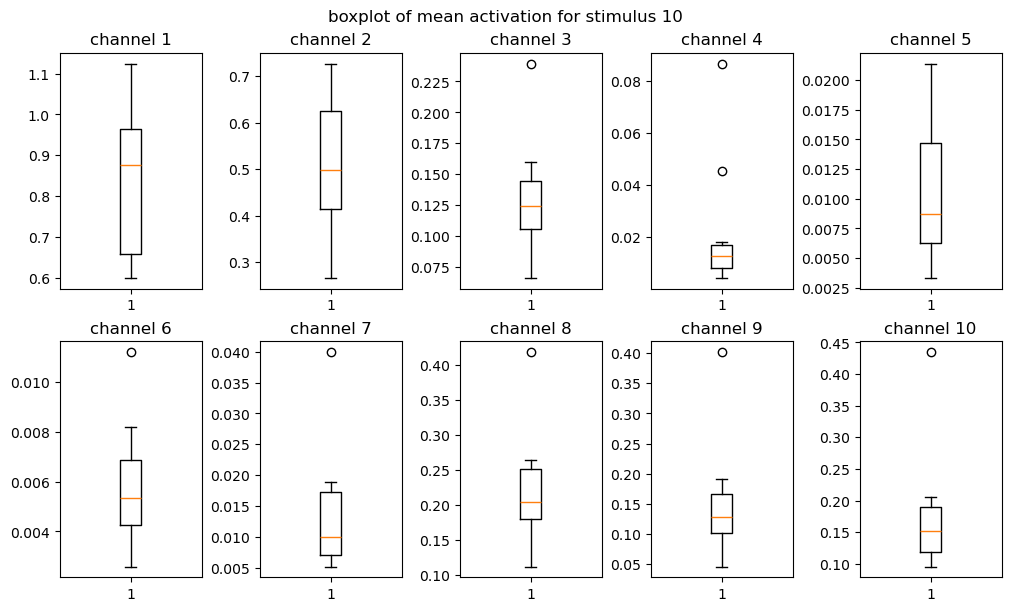

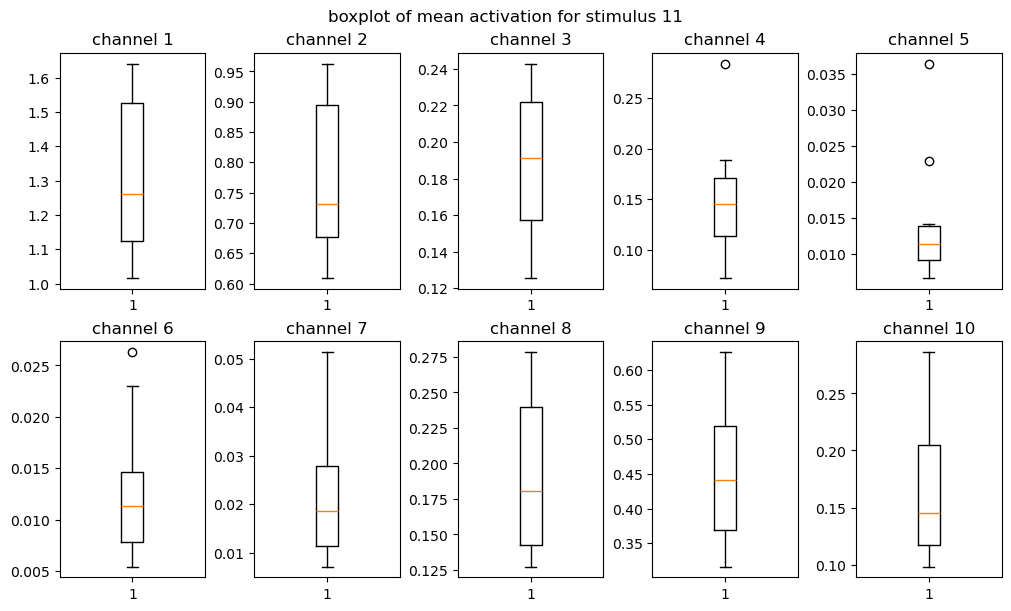

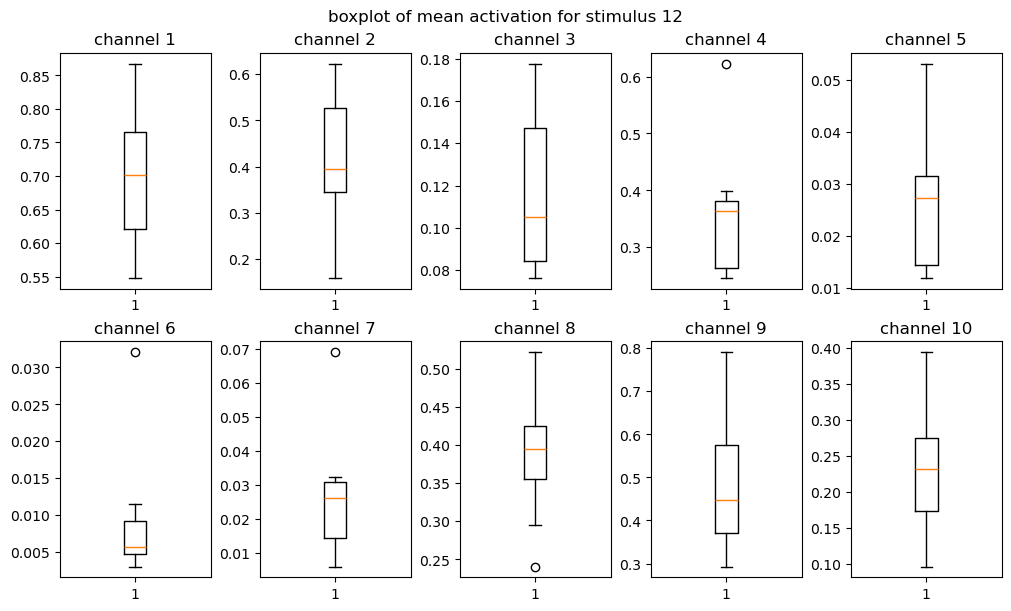

In [12]:
for stimuli_idx in range(n_stimuli):
    fig, ax = plt.subplots(2, 5, figsize=(10, 6),constrained_layout=True)
    ax = ax.ravel()
    plt.suptitle("boxplot of mean activation for stimulus {}".format(stimuli_idx +1))
    for channel_idx in range(n_channels):
        ax[channel_idx].boxplot(emg_average_activations[channel_idx, stimuli_idx, :])
        ax[channel_idx].set_title("channel {}".format(channel_idx +1))
    plt.show()

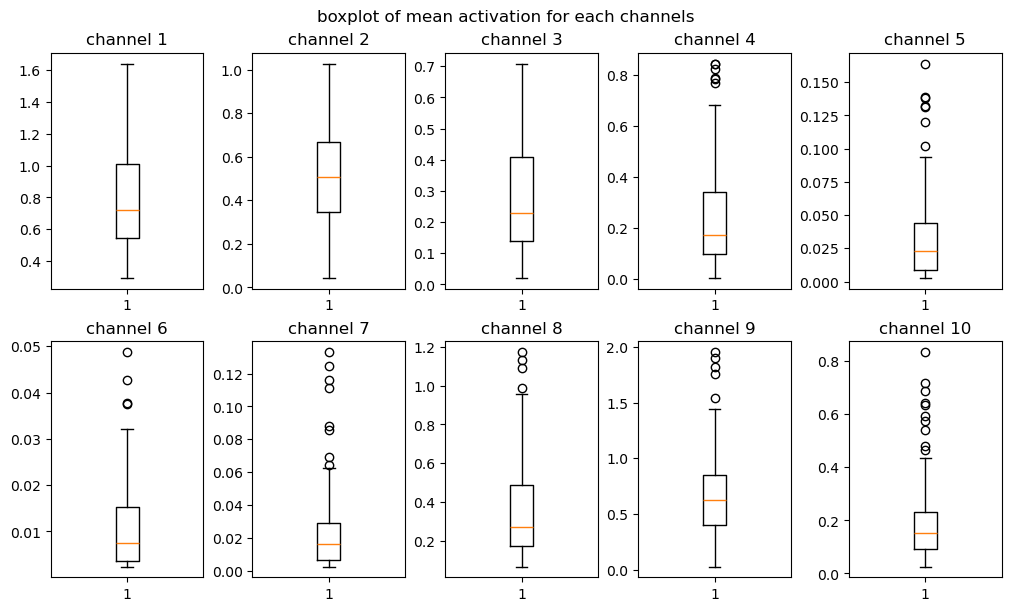

In [13]:
#with and without sharing the axis 
#fig, ax = plt.subplots(2, 5, figsize=(10, 6),constrained_layout=True, sharex=True, sharey=True)
fig, ax = plt.subplots(2, 5, figsize=(10, 6),constrained_layout=True)
ax = ax.ravel()

for channel_idx in range(n_channels):
    ax[channel_idx].boxplot(emg_average_activations[channel_idx, :, :].flatten())
    ax[channel_idx].set_title("channel {}".format(channel_idx +1))
plt.suptitle("boxplot of mean activation for each channels")

plt.savefig("plot/boxplot_all.png")

In [14]:
print(emg_average_activations.shape)
mean_trials = []
max_trials = []
min_trials = []
#for each trials
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        mean_trials.append(np.mean(emg_average_activations[:, stimuli_idx, repetition_idx]))
        max_trials.append(np.max(emg_average_activations[:, stimuli_idx, repetition_idx]))
        min_trials.append(np.min(emg_average_activations[:, stimuli_idx, repetition_idx]))

print(len(mean_trials))

(10, 12, 10)
120


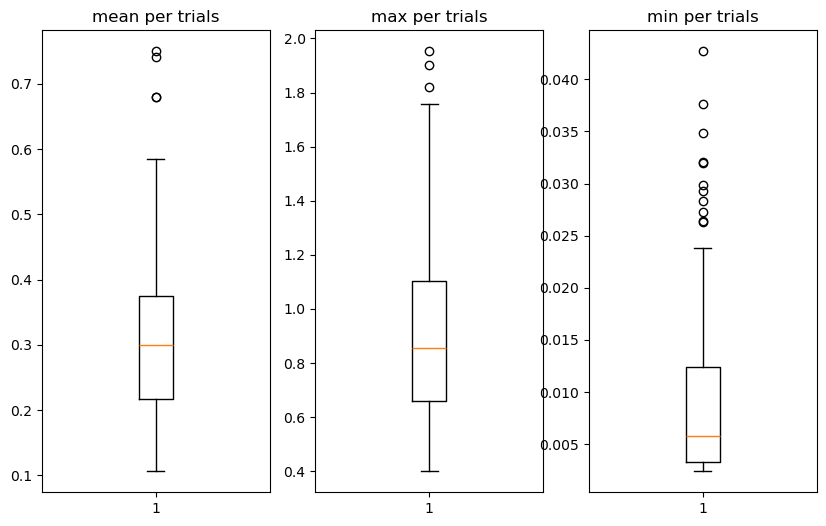

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
ax = ax.ravel()

mean_boxplot = ax[0].boxplot(mean_trials)
ax[0].set_title("mean per trials")

max_boxplot = ax[1].boxplot(max_trials)
ax[1].set_title("max per trials")

min_boxplot = ax[2].boxplot(min_trials)
ax[2].set_title("min per trials")

plt.savefig("plot/boxplot.png")

We will look at trials with extreme value. 

In [16]:
# high mean
high_mean = [i+1 for i, n in enumerate(mean_trials) if n > 0.6]
# low mean
low_mean = [i+1 for i, n in enumerate(mean_trials) if n < 0.2]

# high max
high_max = [i+1 for i, n in enumerate(max_trials) if n > 1.8]
# low max
low_max = [i+1 for i, n in enumerate(max_trials) if n < 0.5]

# high min
high_min = [i+1 for i, n in enumerate(max_trials) if n > 0.025]
# low min
low_min = [i+1 for i, n in enumerate(mean_trials) if n < 0.002]

print("trials with high mean (outlier) are ",high_mean)
#print("trials with low mean are ",low_mean)

print("trials with high max are ",high_max)
#print("trials with low max are ",low_max)

print("trials with high min are ",high_min)
#print("trials with low min are ",low_min)

trials with high mean (outlier) are  [61, 62, 63, 64]
trials with high max are  [61, 62, 63]
trials with high min are  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]


the minimum is not really a problem, since there is channel that don't catch that much data. Hoewever, some trials have a high value.

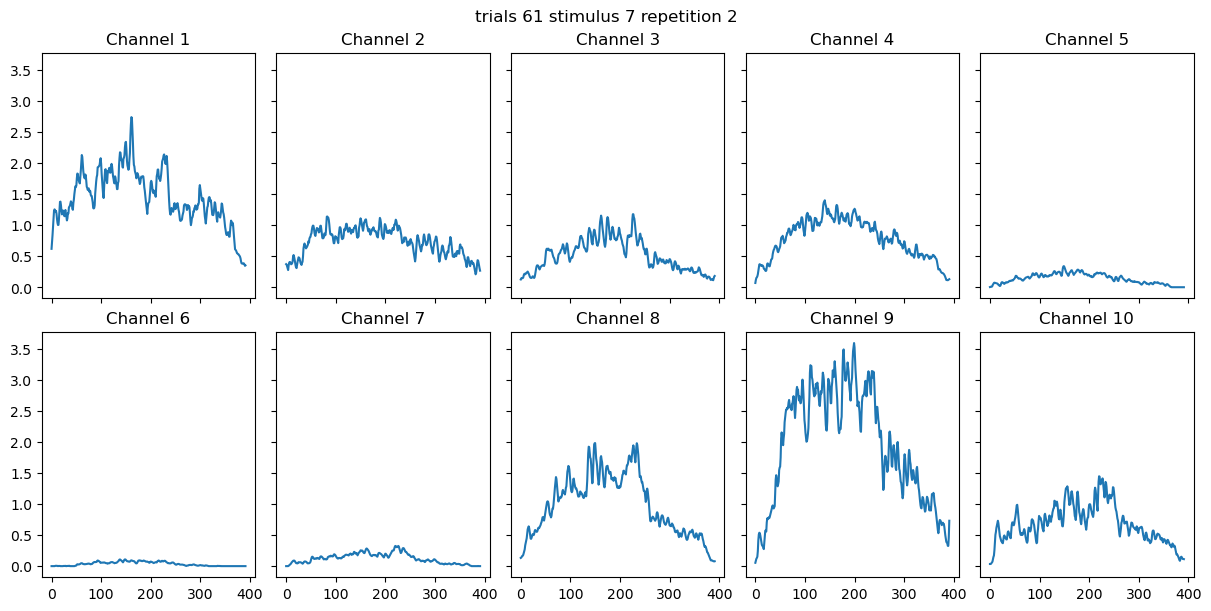

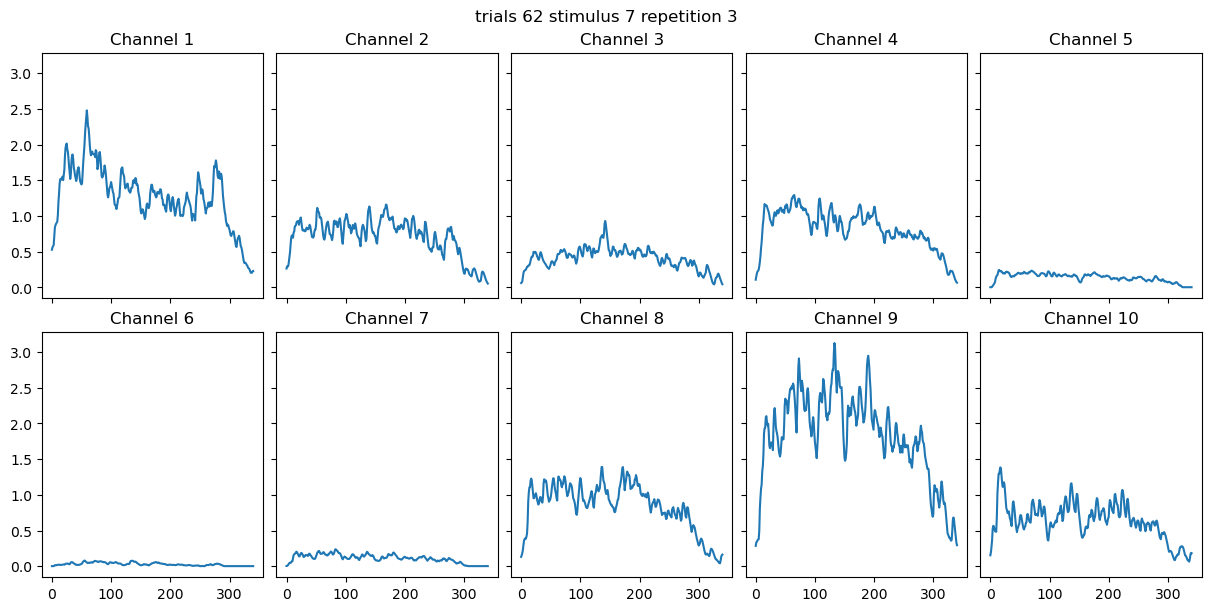

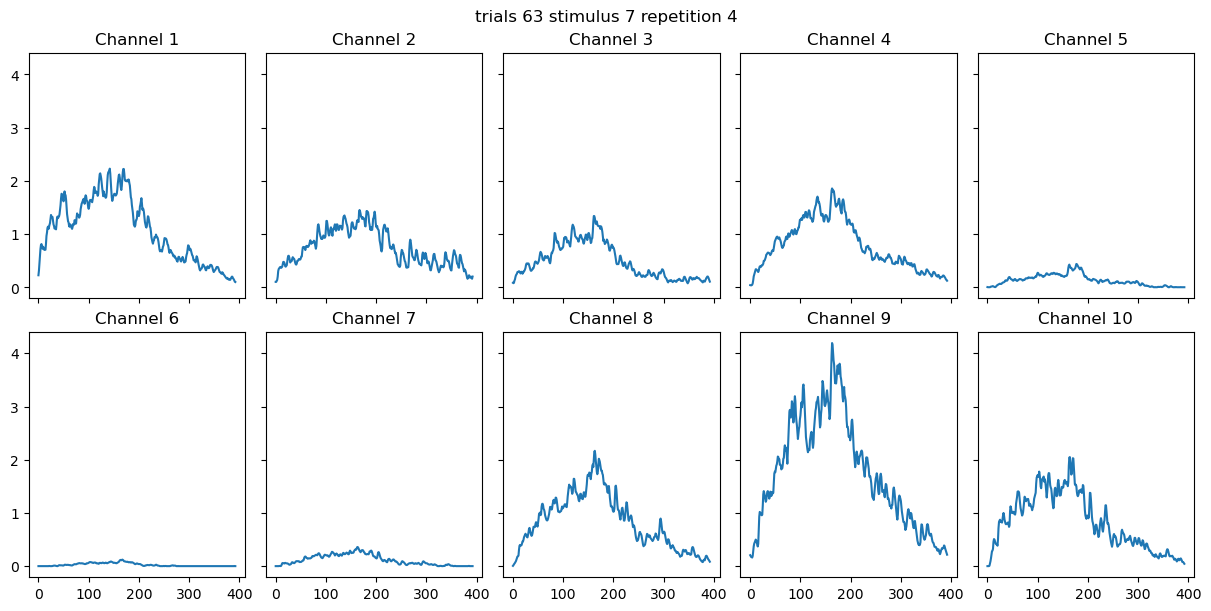

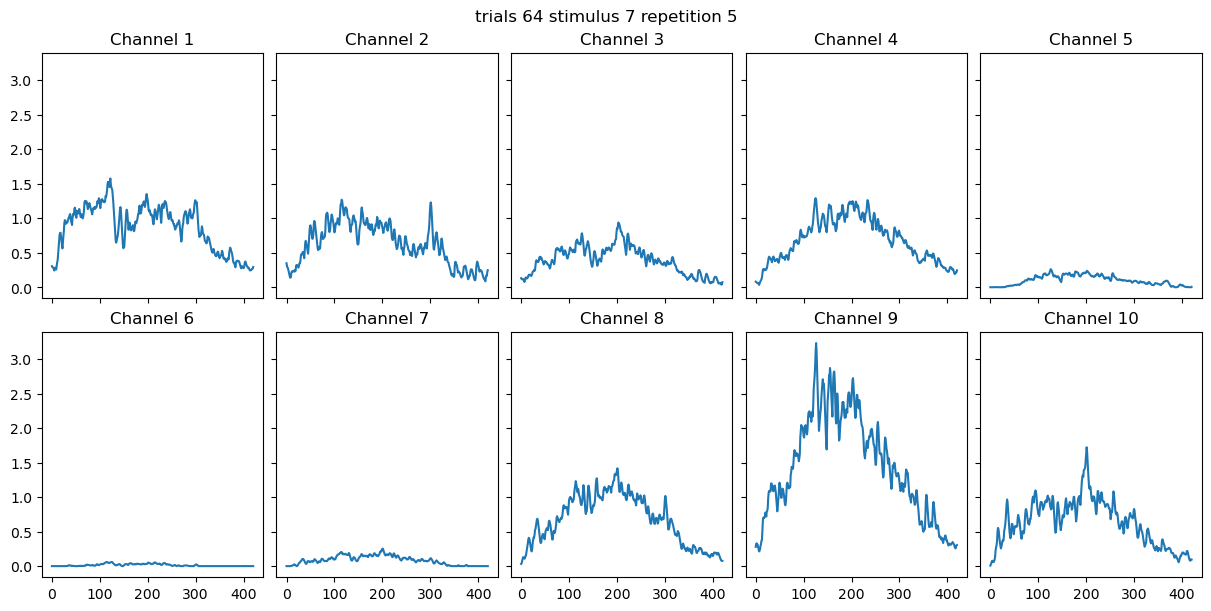

In [17]:
for trials in high_mean :
    stimulus_data = trials//n_repetitions
    repetition_data = trials%n_repetitions
    
# Plot EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    
    # 10 EMG channels
    number_of_emg_channels = emg.shape[-1]
    
    for channel_idx in range(number_of_emg_channels):
        ax[channel_idx].plot(emg_windows[stimulus_data][repetition_data][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
    
    plt.suptitle("trials {} stimulus {} repetition {}".format(trials,stimulus_data+1,repetition_data+1))


Channel 9 show a signal with a high amplitude, but the result is not aberrant. Recall that channel 9 to correspond to the muscles' flexor digitorum superficialis, and stimulus 7 is little finger flexion.

#### Try some preprocessing
In the corresponding paper, an additional filtering step (Butterworth low-pass filter) is applyed on the data. We decided to investigate the data in the frequency domain and try some filters.

In [18]:
#1st order Butterworth low-pass filter with 1Hz cutoff frequency
fs = 100
cutoff_frequency = 1
sos = butter(N=4, Wn=cutoff_frequency, fs=fs, btype="lowpass", output="sos") 
emg_filtered_but = sosfiltfilt(sos, emg.T).T 

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

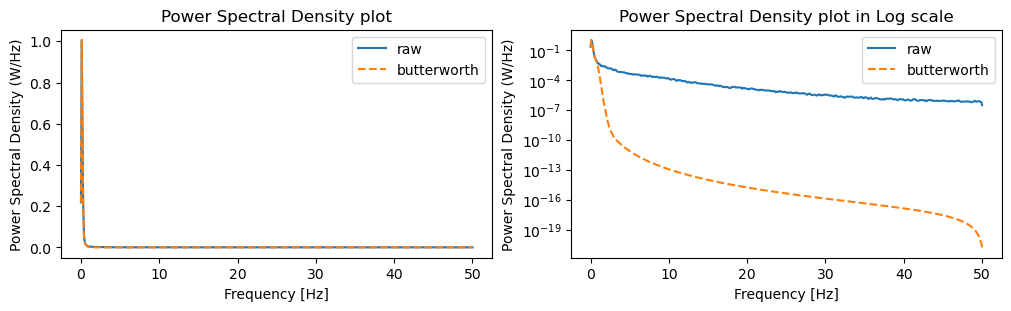

In [19]:
#check how power density changed after filtering 
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_but, Pxx_but = welch(emg_filtered_but[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_but, Pxx_but, linestyle="--", label="butterworth")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_but, Pxx_but, linestyle="--", label="butterworth")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

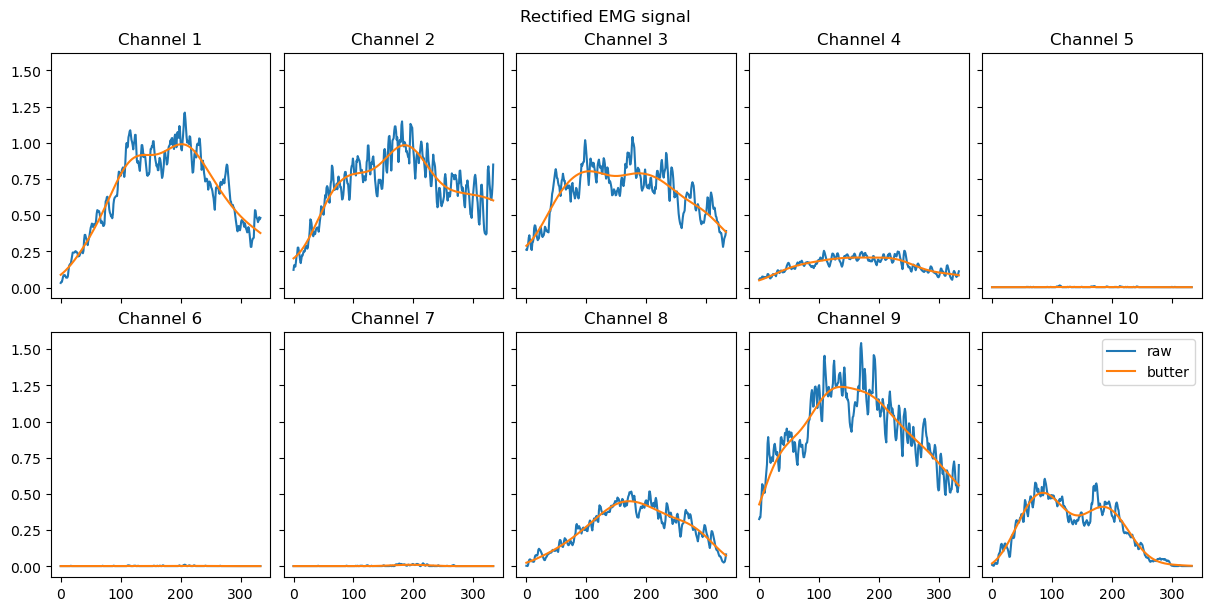

In [20]:
emg_windows_filtered_but = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows_filtered_but[stimuli_idx][repetition_idx] = emg_filtered_but[idx, :]
        
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[1][0][:, channel_idx], label = "raw")
    ax[channel_idx].plot(emg_windows_filtered_but[1][0][:, channel_idx], label = "butter")
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")
plt.legend()
plt.show()

The Butterworth filter is smoothing the signal and could have been use as a additionnal processing steps. After testing with the model, we decided to keep the raw signal. 

### 2 Split the data into train/test/validation sets

#### reformat the data

We will reformat the data into trials before splitting.
For now, emg_windows have the format stimulus * repetition * trials (with different format for each trials).
For simplicity, we will reformat to trials and assign labels.

In [21]:
print("recall, number of trials".format(n_stimuli*n_repetitions))

#current format
print(len(emg_windows))
print(len(emg_windows[0]))
print(emg_windows[0][0].shape)

# Flatten using Nested Loops
dataset = []
label = np.zeros(n_stimuli*n_repetitions)

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        dataset.append(emg_windows[stimuli_idx][repetition_idx])
        label[stimuli_idx*n_repetitions + repetition_idx] = stimuli_idx +1 
        
print(f"dataset size: {len(dataset)}")
print(f"trial 1 dimension (example): {dataset[0].shape}")
print(f"trial 2 dimension (example): {dataset[1].shape}")
print(f"labels dimension: {label.shape}")

recall, number of trials
12
10
(307, 10)
dataset size: 120
trial 1 dimension (example): (307, 10)
trial 2 dimension (example): (390, 10)
labels dimension: (120,)


#### Splitting the data
As we will perform cross-validation, we only need to split the data between a training and a testing set.

In [22]:
# Split the dataset into training and testing sets
train_ratio = 0.80

# Here, 80% of the data is reserved for training
data_train, data_test, y_train, y_test = train_test_split(dataset, 
                                                          label, 
                                                          test_size=1 - train_ratio, 
                                                          random_state=random_seed,
                                                          stratify=label)

print(f"train size: {len(data_train)}")
print(f"trial train 1 dimension (example): {data_train[0].shape}")
print(f"train size: {len(data_test)}")
print(f"trial test 1 dimension (example): {data_test[0].shape}")

train size: 96
trial train 1 dimension (example): (384, 10)
train size: 24
trial test 1 dimension (example): (377, 10)


In [23]:
#we have the same number of each !
pd.DataFrame(y_train).value_counts()

0   
1.0     8
2.0     8
3.0     8
4.0     8
5.0     8
6.0     8
7.0     8
8.0     8
9.0     8
10.0    8
11.0    8
12.0    8
Name: count, dtype: int64

### 3 Extract features and explore them

#### Create the features

In [24]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1])) < 0,
    axis=0
)

#### extract the features

In [25]:
def extract_features(emg_dataset, features):

    n_samples = len(emg_dataset)
    print("sample size", n_samples)
    n_channels = emg_dataset[0].shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    print("number of features",n_features)
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))

    for i in range(n_samples) :
        current_feature_index = 0
        # Loop over each feature function provided
        for feature in features:
            # Determine the indices in the dataset where the current feature will be stored
            selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
            # Apply the feature function to the selected EMG data and store the result
            dataset[i, selected_features] = feature(emg_dataset[i])
            # Update the feature index for the next feature
            current_feature_index += n_channels

    # Return the constructed dataset and corresponding labels
    return dataset

X_train = extract_features(data_train, features=[mav, std, maxav, rms, wl, ssc])
X_test = extract_features(data_test, features=[mav, std, maxav, rms, wl, ssc])

print("train and test dataset dimension {} {}".format(X_train.shape,X_test.shape))

sample size 96
number of features 60
sample size 24
number of features 60
train and test dataset dimension (96, 60) (24, 60)


#### exploration (using training data)

First, lets look at the mean and standard deviation of each features accross channels.

In [26]:
features=["mav", "std", "maxav", "rms", "wl", "ssc"]
nb_features = len(features)
col = [f"channel {i}" for i in range(1, n_channels+1)]

DataMean = pd.DataFrame(X_train.mean(axis = 0).reshape(nb_features,n_channels),columns=col, index=features)
DataSTD = pd.DataFrame(X_train.std(axis = 0).reshape(nb_features,n_channels),columns=col, index=features)
DataMean

channel 1  channel 2  channel 3  channel 4  channel 5  channel 6  \
mav     0.781671   0.505636   0.282418   0.245589   0.033843   0.011519   
std     0.341815   0.209564   0.132256   0.162932   0.031622   0.012558   
maxav   1.513822   1.020073   0.603158   0.624621   0.133926   0.056995   
rms     0.856770   0.552675   0.314638   0.297473   0.046924   0.017284   
wl     11.058647  11.306959   5.957879   4.525302   1.111284   0.397558   
ssc    94.270833  95.177083  81.406250  66.208333  37.281250  17.510417   

       channel 7  channel 8  channel 9  channel 10  
mav     0.024561   0.363560   0.665237    0.193757  
std     0.024144   0.224928   0.356226    0.140415  
maxav   0.099131   0.879341   1.484881    0.557863  
rms     0.034729   0.429849   0.761825    0.241455  
wl      0.795945   6.143752  13.624372    4.294092  
ssc    29.802083  75.843750  84.447917   62.854167

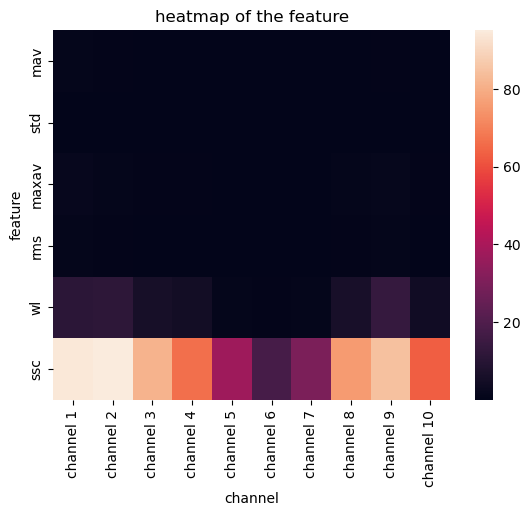

In [27]:
sns.heatmap(DataMean, cbar = True)
plt.xlabel("channel")
plt.ylabel("feature")
plt.title("heatmap of the feature")
plt.savefig("plot/heatmap_features.png")

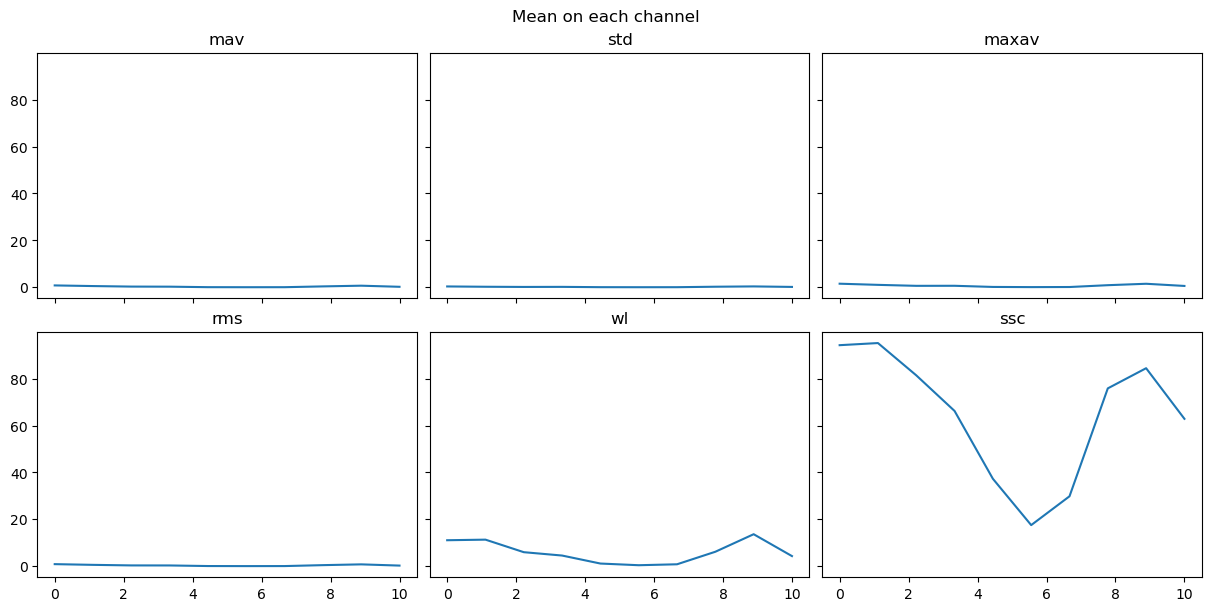

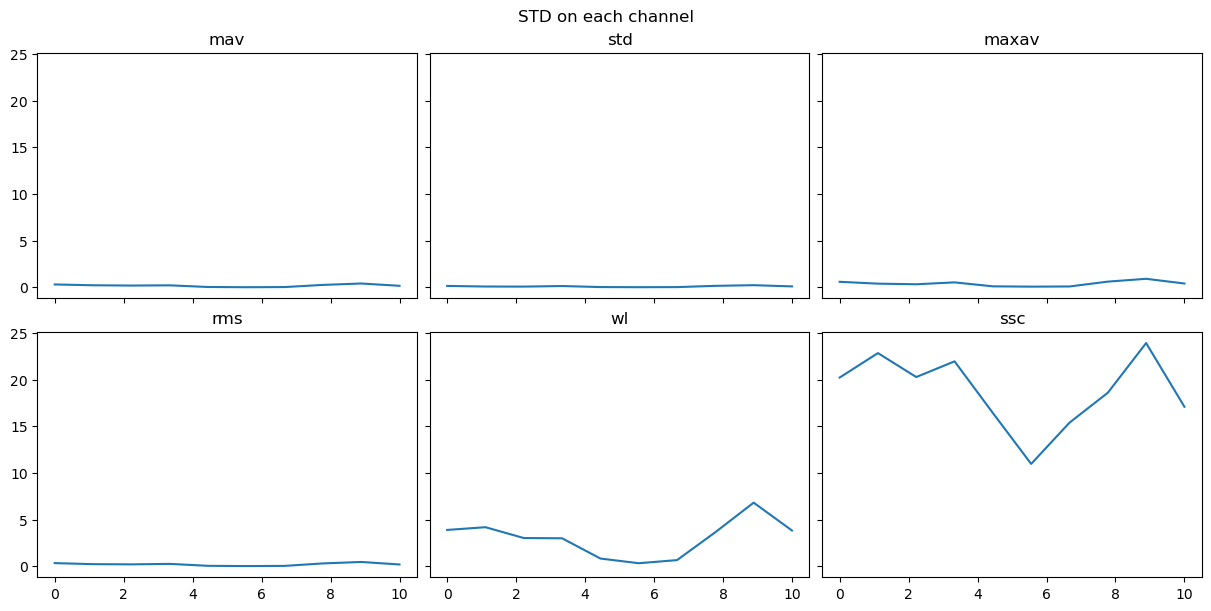

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True,sharex=True,sharey=True)
ax = ax.ravel()

for feature in range(nb_features): 
    ax[feature].plot(np.linspace(0,n_channels,n_channels),DataMean.iloc[feature])
    ax[feature].set_title(features[feature])
plt.suptitle("Mean on each channel")
plt.show()

fig, ax = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True,sharex=True,sharey=True)
ax = ax.ravel()

# plot Rectified EMG signal
for feature in range(nb_features): 
    ax[feature].plot(np.linspace(0,n_channels,n_channels),DataSTD.iloc[feature])
    ax[feature].set_title(features[feature])
plt.suptitle("STD on each channel")
plt.show()

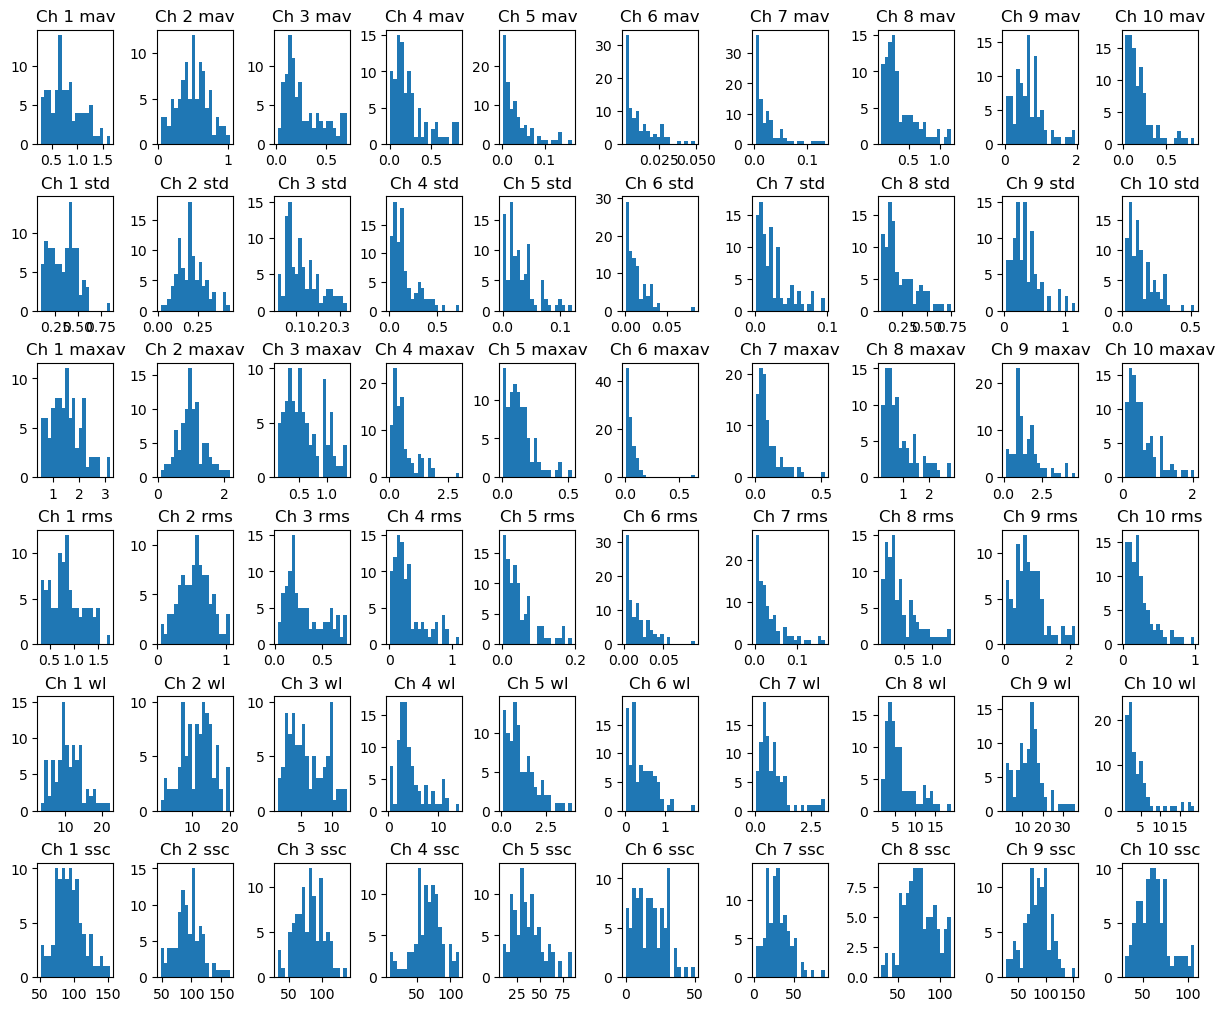

In [29]:
fig, ax = plt.subplots(nb_features,n_channels, figsize=(12, 10), constrained_layout=True)
ax = ax.ravel()

for feature in range(nb_features) :
    for channel in range(n_channels):
        ax[feature*n_channels+channel].hist(X_train[:,feature*n_channels+channel],bins=20)
        ax[feature*n_channels+channel].set_title("Ch " + str(channel +1) + " " + features[feature])

plt.savefig("plot/histogram_parameter.png")

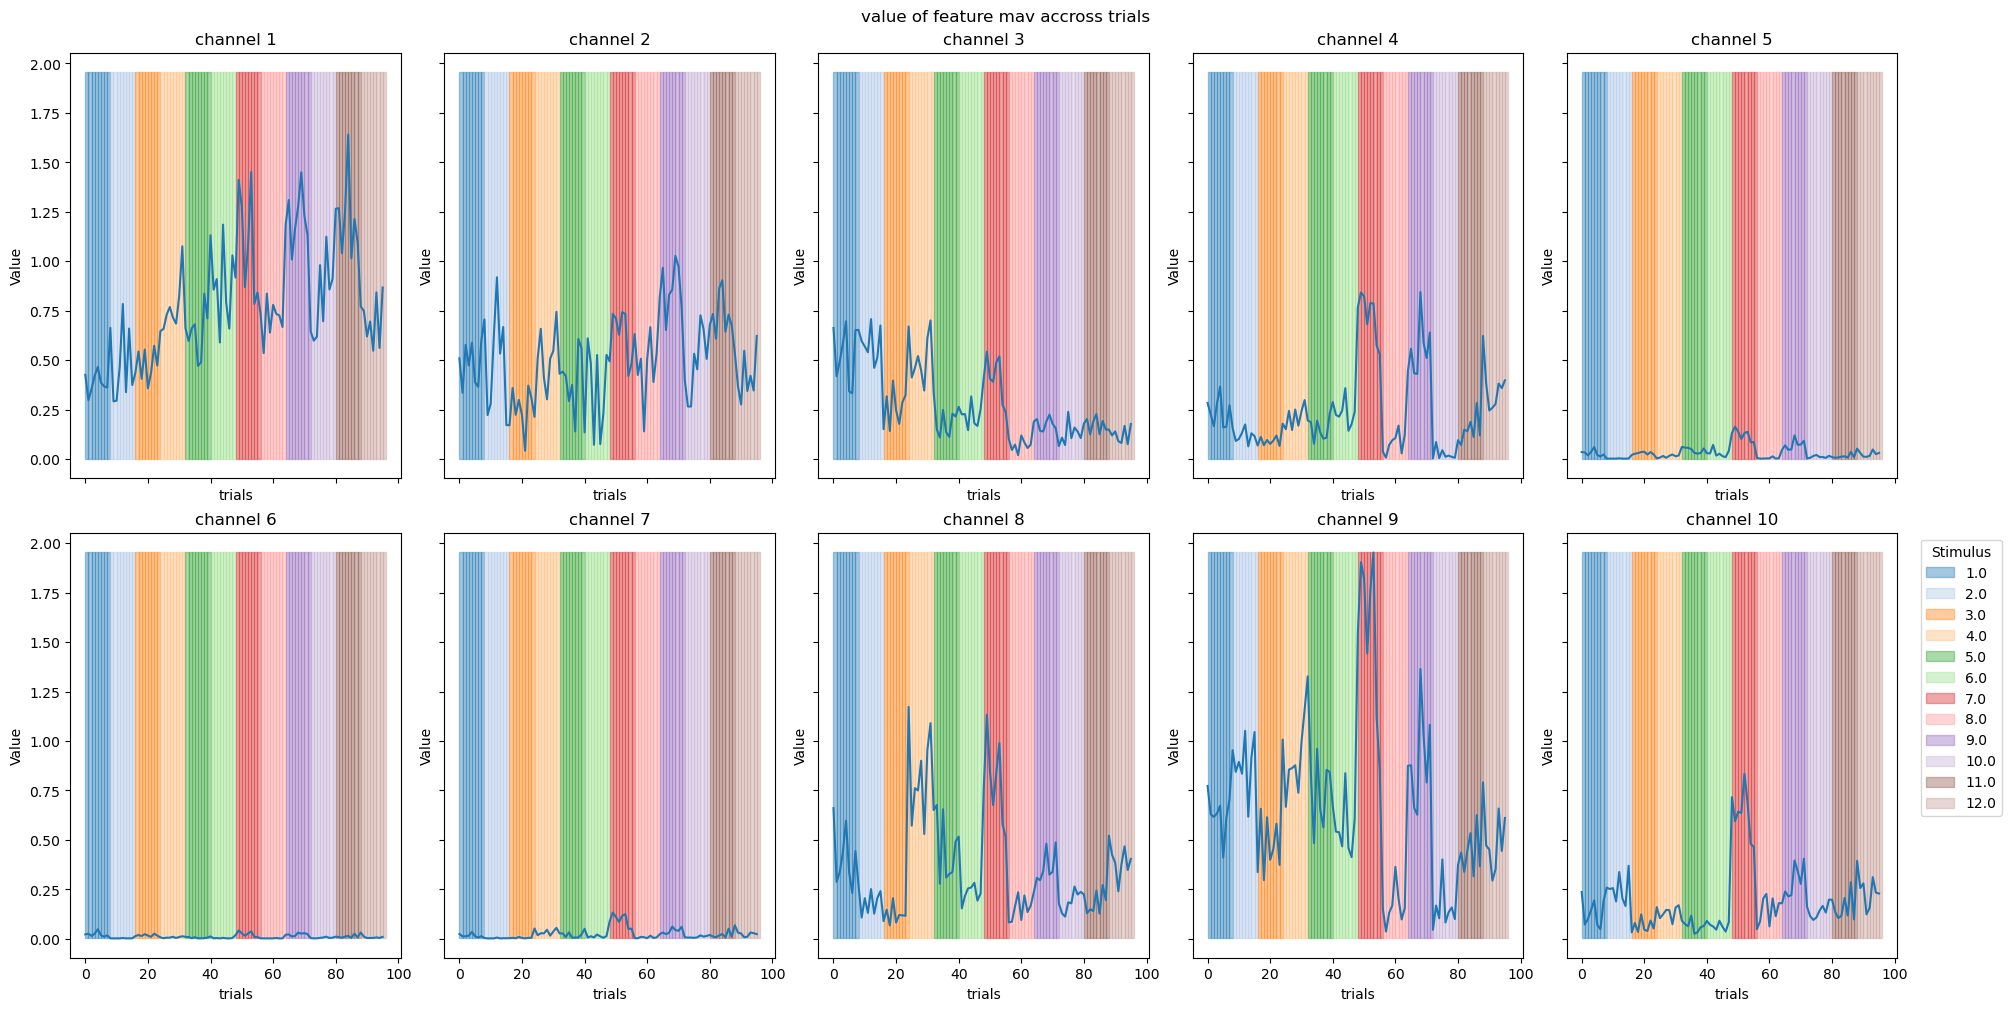

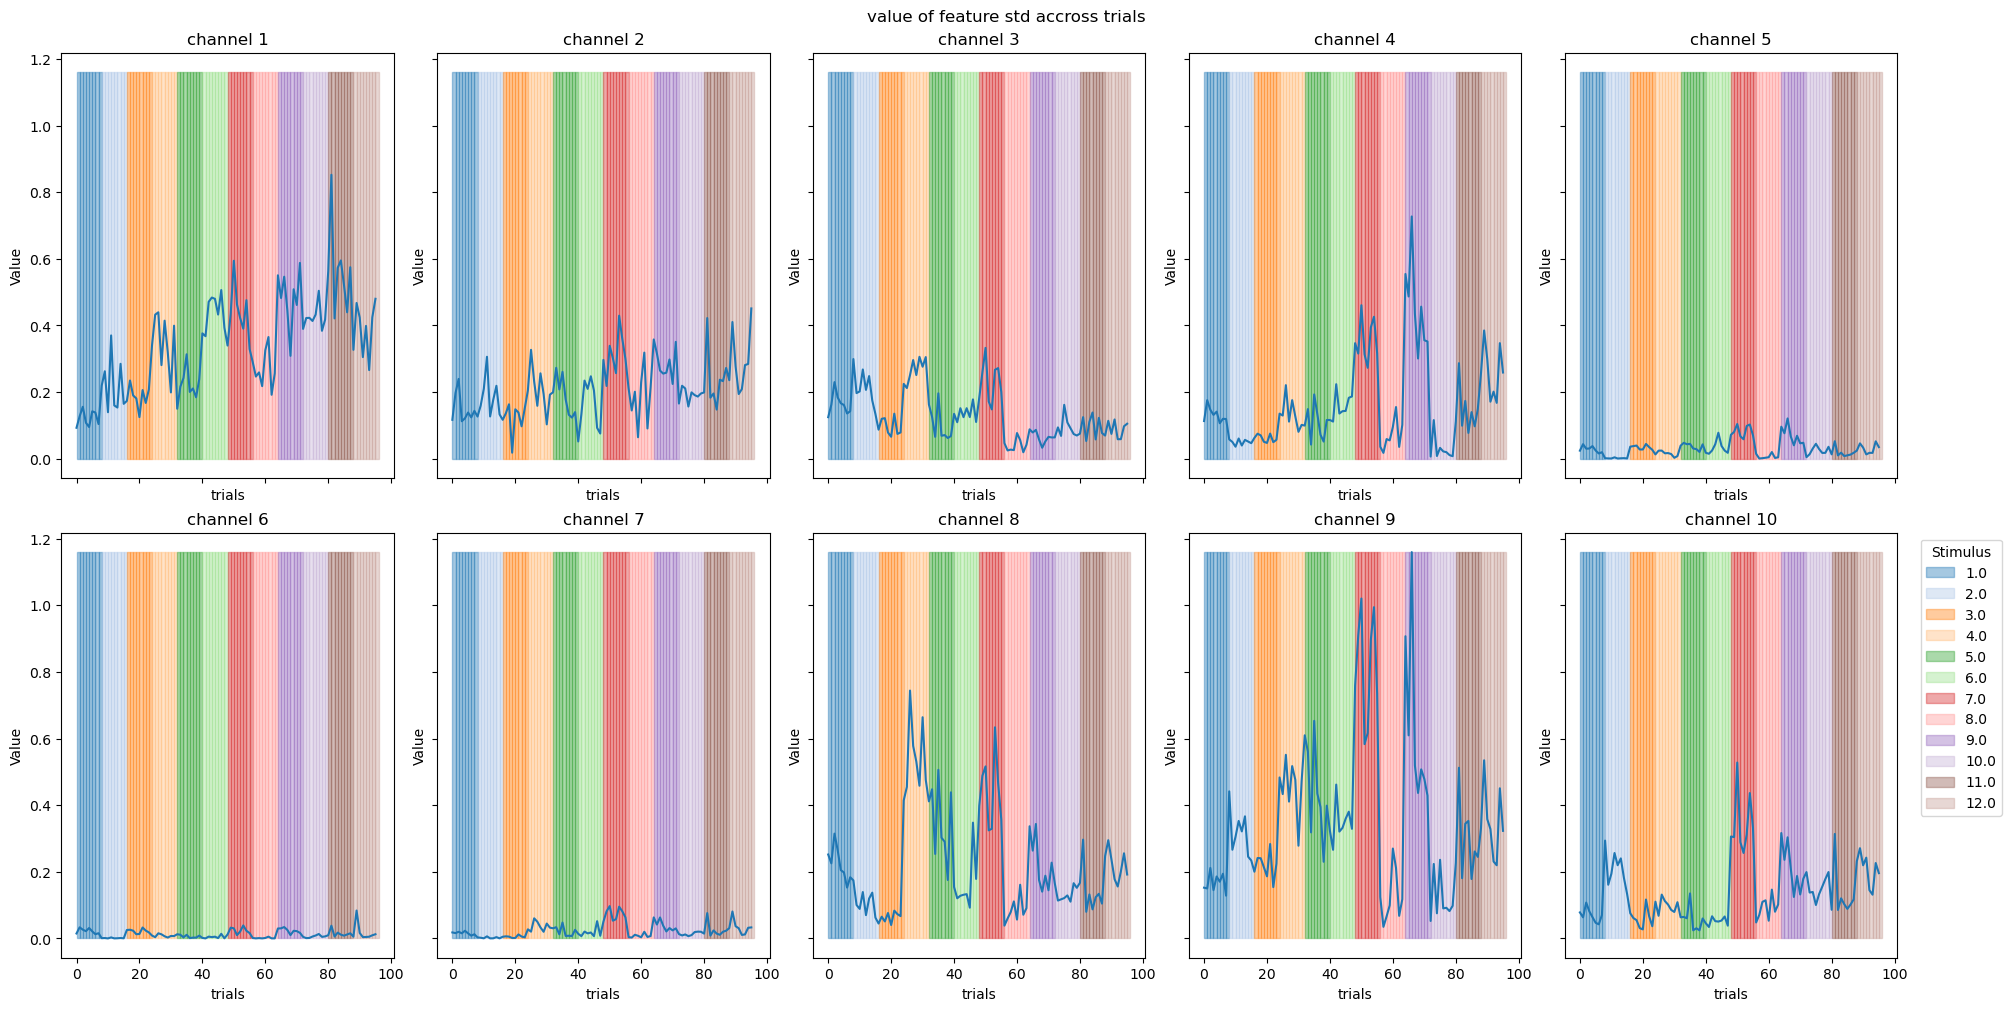

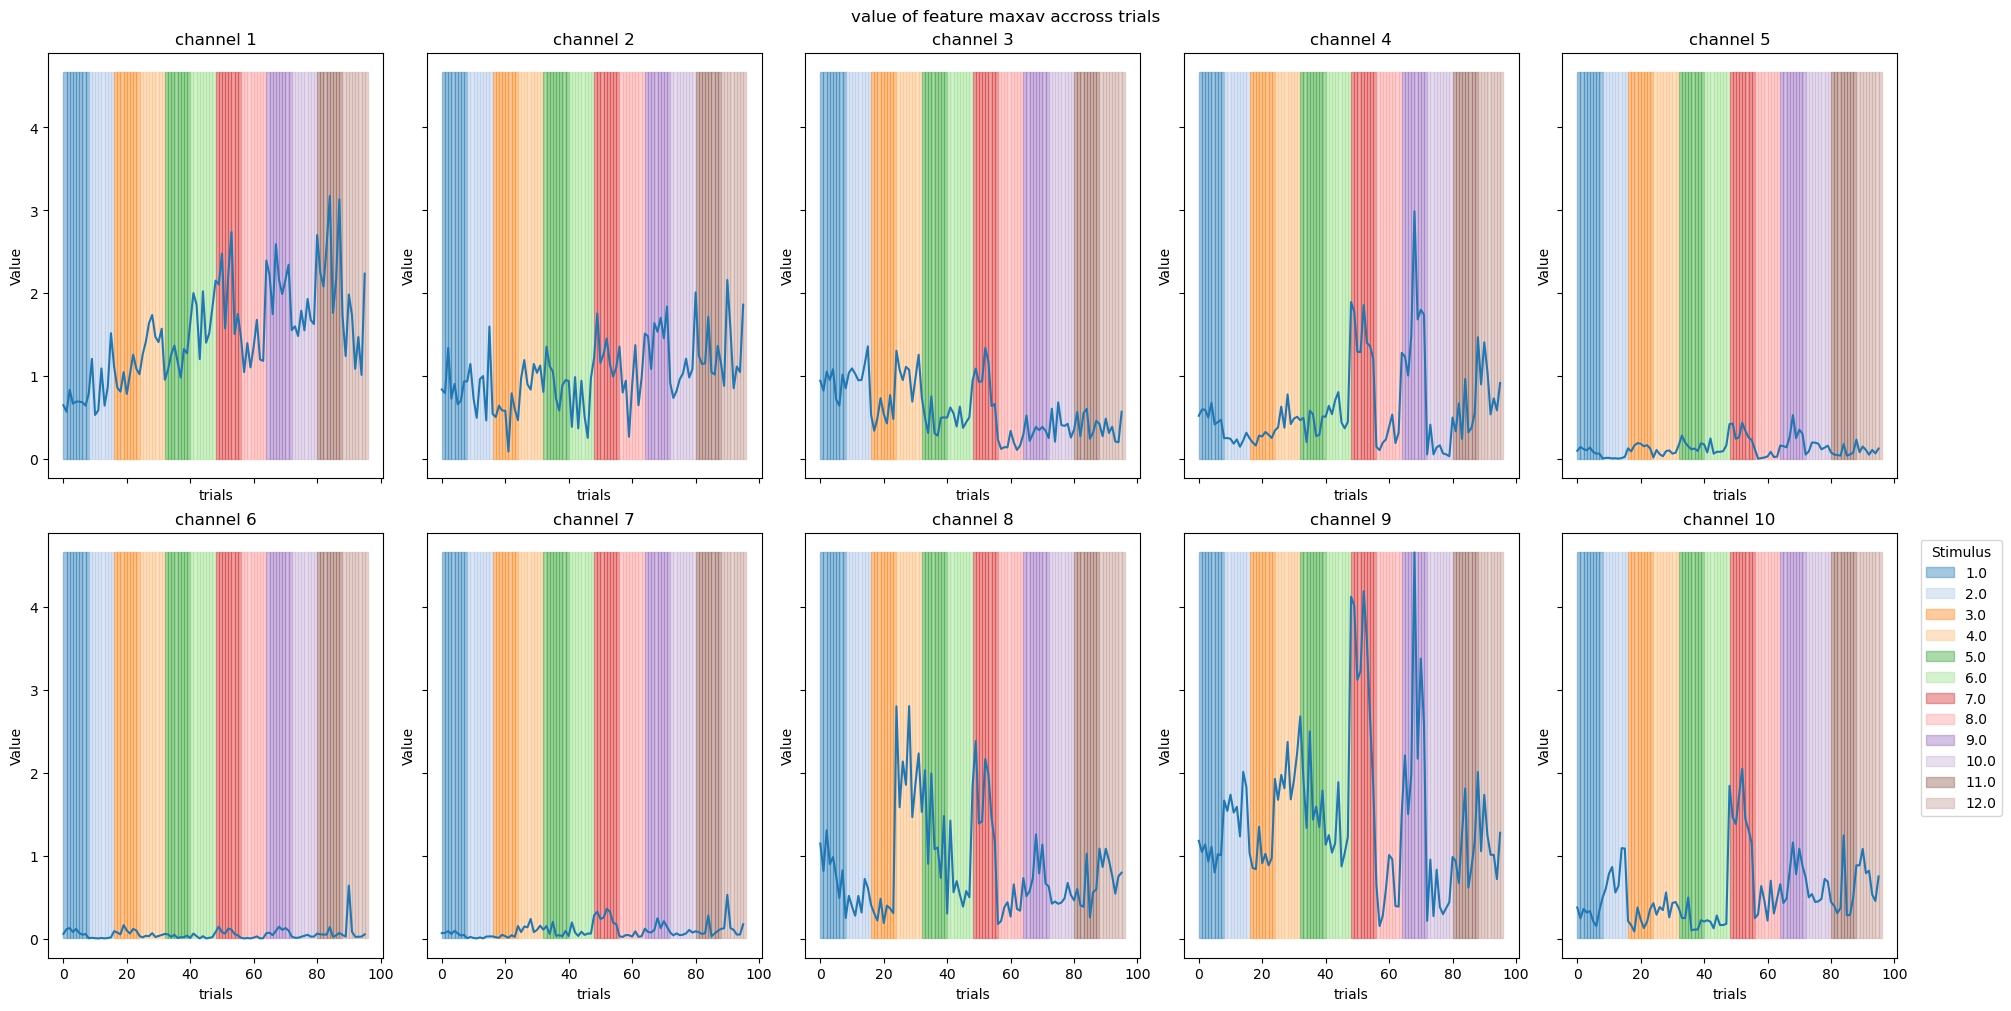

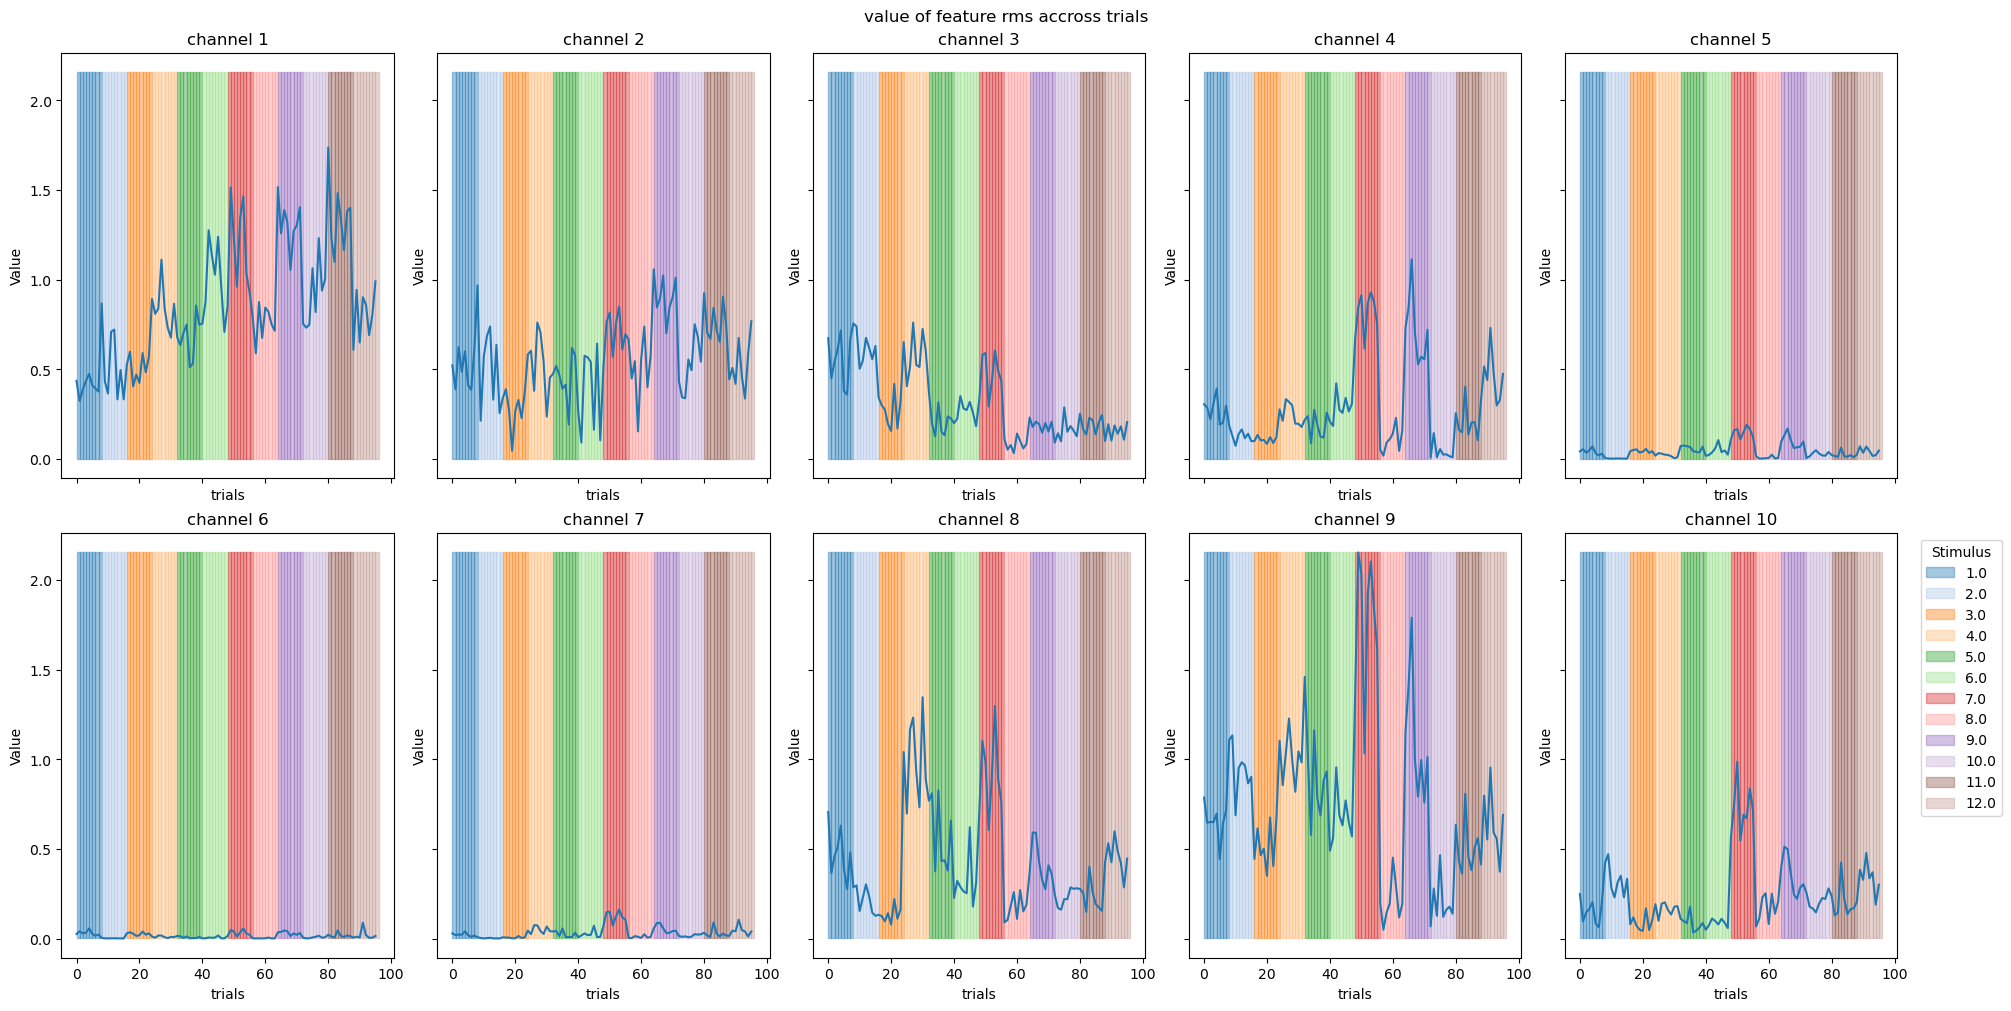

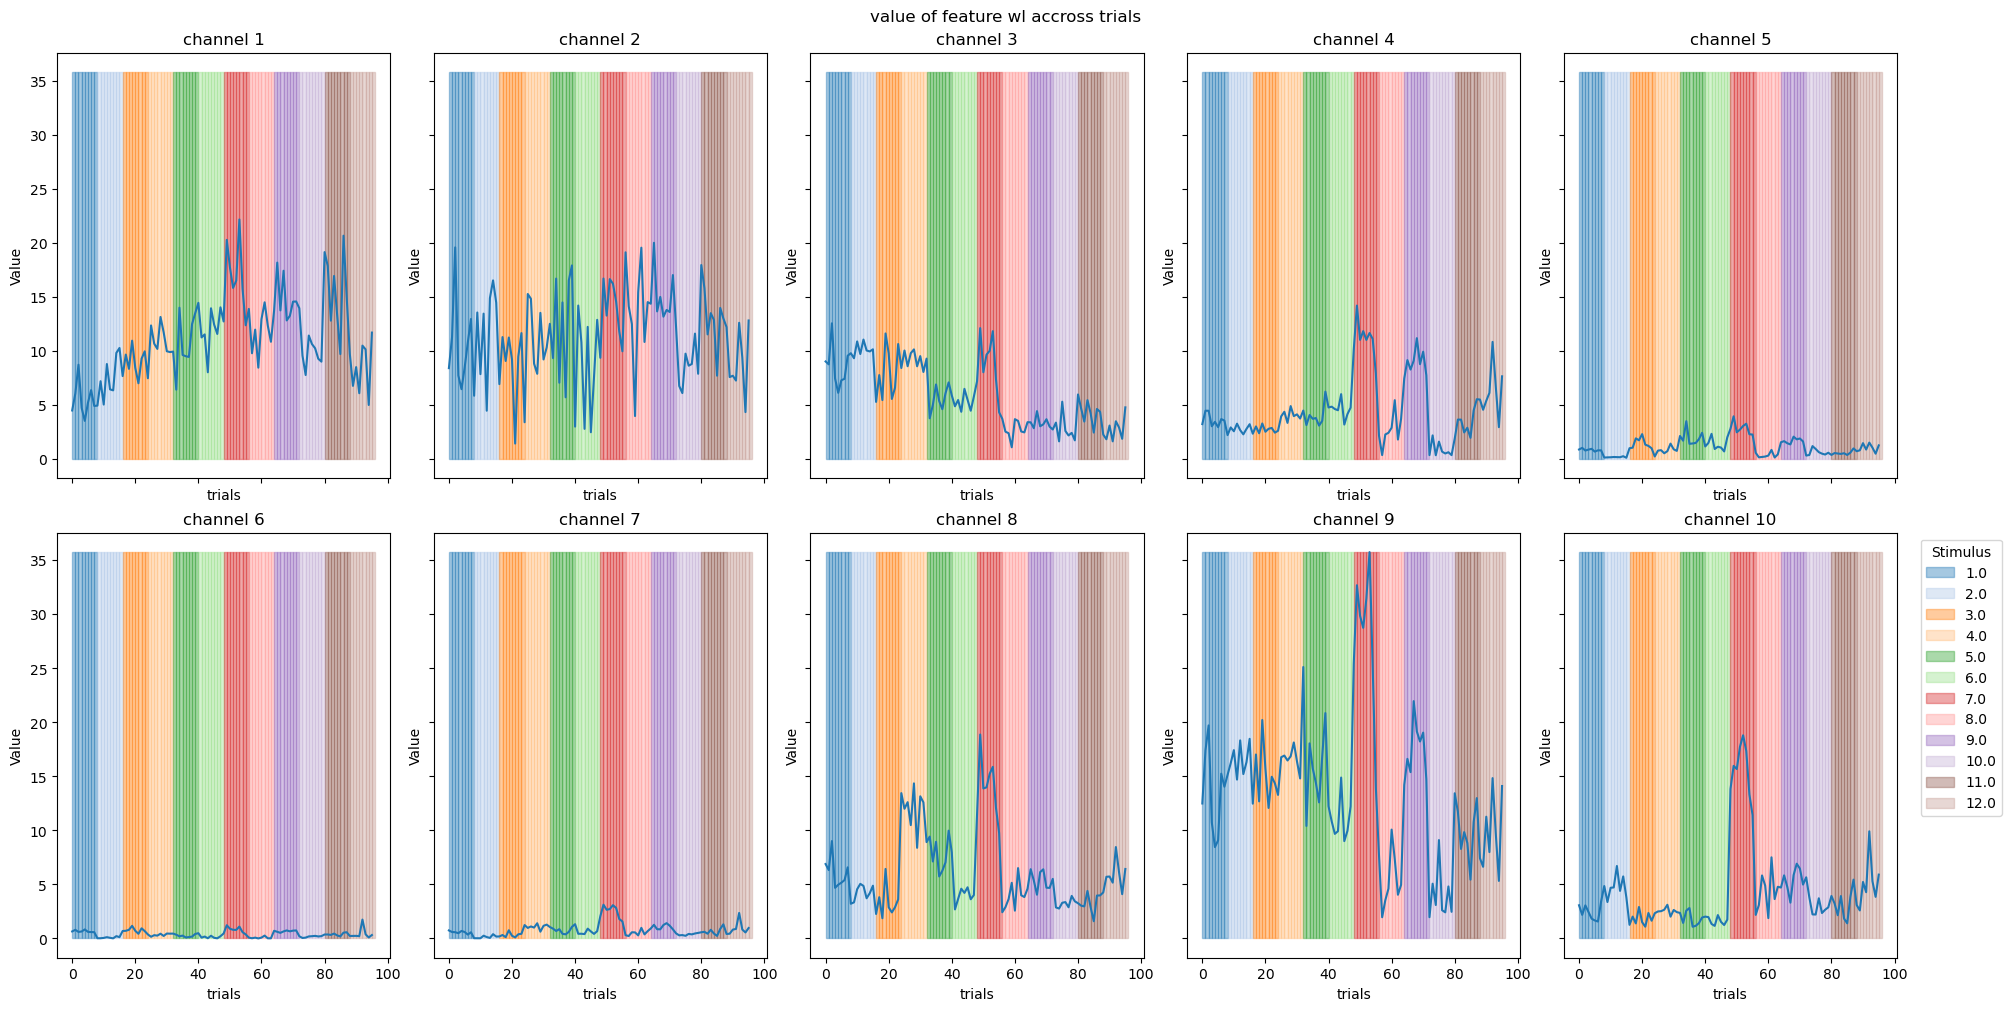

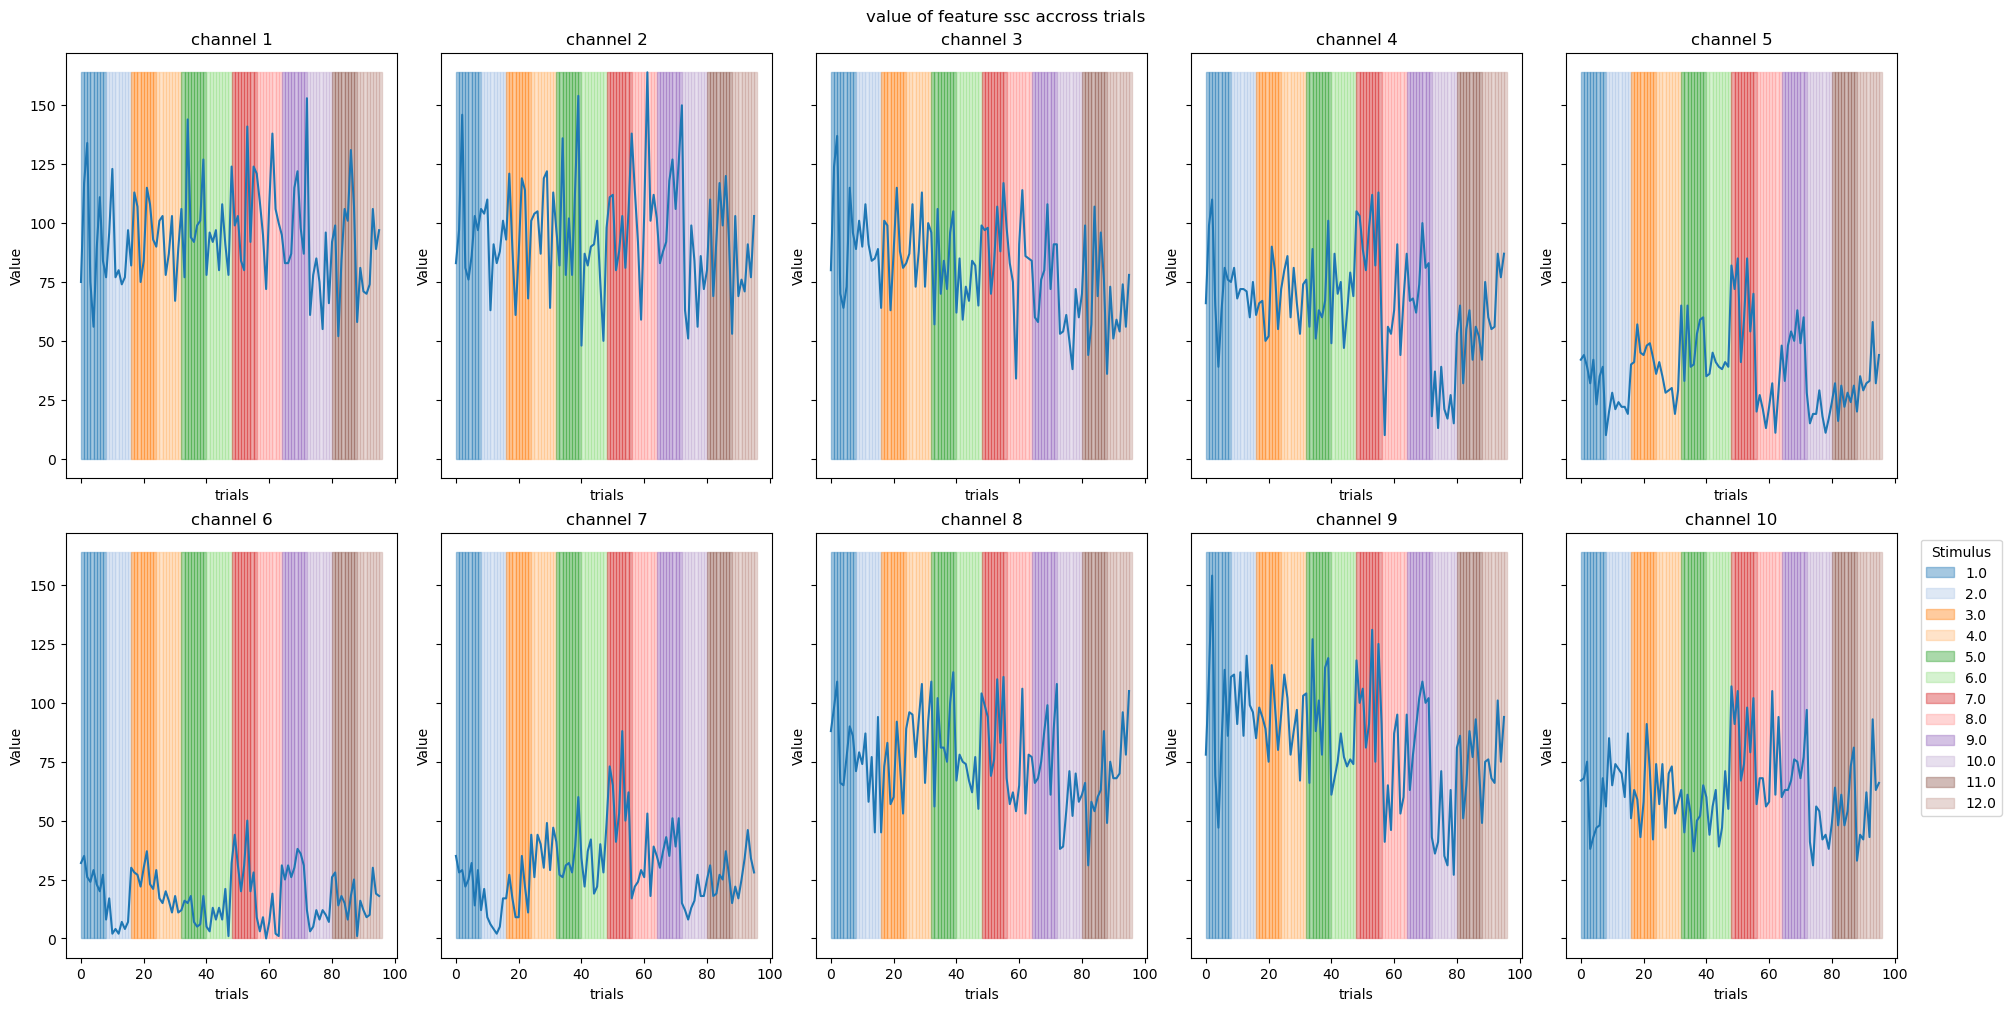

In [30]:
def plot_data(dataset,labels,sort = True):
    colors = sns.color_palette("tab20", n_colors=12) 
        
    for feature_nb,feature in enumerate(features) : 
        fig, ax = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True, sharex=True, sharey=True)
        ax = ax.ravel()

        ymin = min(dataset[:,feature_nb*n_channels:(feature_nb+1)*n_channels].flatten())
        ymax = max(dataset[:,feature_nb*n_channels:(feature_nb+1)*n_channels].flatten())

        if sort :
            sorted_indices = np.argsort(labels)
            labels = labels[sorted_indices]
            dataset = dataset[sorted_indices]
            
        for channel in range(n_channels):
            # Draw stimulus
            dataplot = dataset[:,feature_nb*n_channels+channel]
            for i, label in enumerate(labels):
                rect = Rectangle((i,ymin), 1, ymax, color=colors[int(label - 1)], alpha=0.4)  # Background rectangle
                ax[channel].add_patch(rect)
            #add feature
            ax[channel].plot(dataplot)
            ax[channel].set_xlabel("trials")
            ax[channel].set_ylabel("Value")
            ax[channel].set_title("channel {}".format(channel+1))
        
        handles = [Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.4) for i in range(12)]  # Create legend patches
        plt.legend(handles, np.linspace(1,n_stimuli,n_stimuli), title="Stimulus", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.suptitle("value of feature {} accross trials".format(feature))
        plt.savefig("plot/features_{}.png".format(feature))

plot_data(X_train,y_train)  
#plot_data(X_test,y_test)  
#plot_data(X_val,y_val)  

### 4 Classification using Random Forest

#### Scaling

In [31]:
# Normalizing the data with a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  
X_test_z = scaler.transform(X_test)   

print("Train shape {}".format(X_train_z.shape))
print("Test shape {}".format(X_test_z.shape))

Train shape (96, 60)
Test shape (24, 60)


#### Hyperparameters optimization : method 1

In [32]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],  # Number of trees
    'max_depth': [None, 10, 20, 30, 40],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider for the best split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,       # 5-fold cross-validation
    random_state=random_seed,
    verbose=2,
    n_jobs=-1   # Use all available cores
)

# Fit the model to the training data
random_search.fit(X_train_z, y_train)

# Get the best parameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': True}


In [33]:
y_pred1 = best_model.predict(X_test_z)
print("Predicted actions:", y_pred1)

Predicted actions: [12.  5.  4.  7.  2.  8.  8.  7. 12. 11.  1. 11.  4.  3.  6. 11. 12. 10.
 10. 11.  3.  9.  2.  1.]


#### Hyperparameters optimization : method 2

In [34]:
param_grid = {
    "n_estimators": [10,50,100,500], #range(10, 100, 10),
    "bootstrap": [True, False],
    "criterion": ['gini', "log_loss"],
    "max_features" : ["sqrt", "log2", 1, 5, 10, None], 
    "max_depth": [None, 10, 20, 30, 40],
    "max_leaf_nodes": range(3,15,5),
}

grid = GridSearchCV(
    RandomForestClassifier(), 
    param_grid, 
    cv=5,       # 5-fold cross-validation
)

In [35]:
grid.fit(X_train_z,y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, ma

In [36]:
y_pred2 = grid.predict(X_test_z)
print("Predicted actions:", y_pred2)

Predicted actions: [ 5.  5.  4.  7.  2.  8.  8.  7. 12. 11.  1. 11.  4.  3. 11. 11. 12. 10.
 10. 11.  3.  9.  2.  1.]


In [37]:
print(grid.best_estimator_)

RandomForestClassifier(max_depth=40, max_leaf_nodes=13, n_estimators=50)


### 5 Evaluate the performance

In [38]:
def evaluation(y_pred,y,name = "") :
    
    #Calculate accuracy
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred,average='weighted')
    precision = precision_score(y,y_pred,average='weighted')
    print(f"Accuracy score : {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"recall Score: {recall}")
    print(f"precision Score: {precision}")

    #Create a confusion matrix
    confmat = confusion_matrix(y, y_pred, normalize="true")
    mask = confmat == 0
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confmat, annot=np.where(mask, "0", confmat.round(2)), fmt="", cmap="Blues", cbar=True, ax=ax)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy score : 0.875
F1 Score: 0.8777777777777777
recall Score: 0.875
precision Score: 0.9375


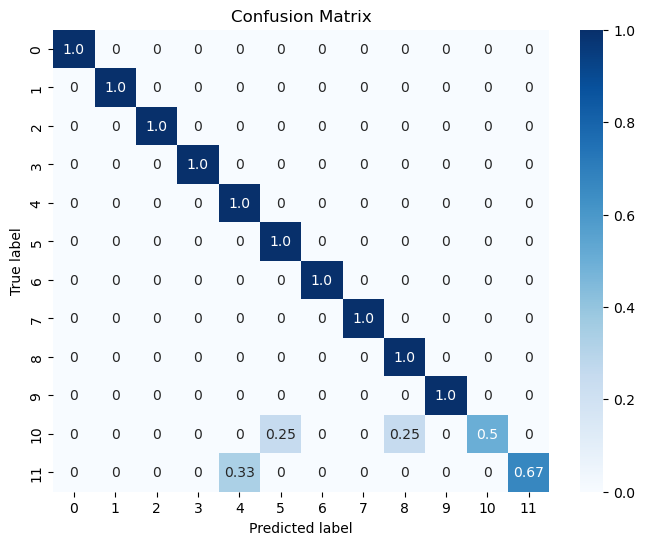

In [39]:
evaluation(y_test, y_pred1)

Accuracy score : 0.875
F1 Score: 0.8968253968253967
recall Score: 0.875
precision Score: 0.9791666666666666


/Users/djay/miniforge3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


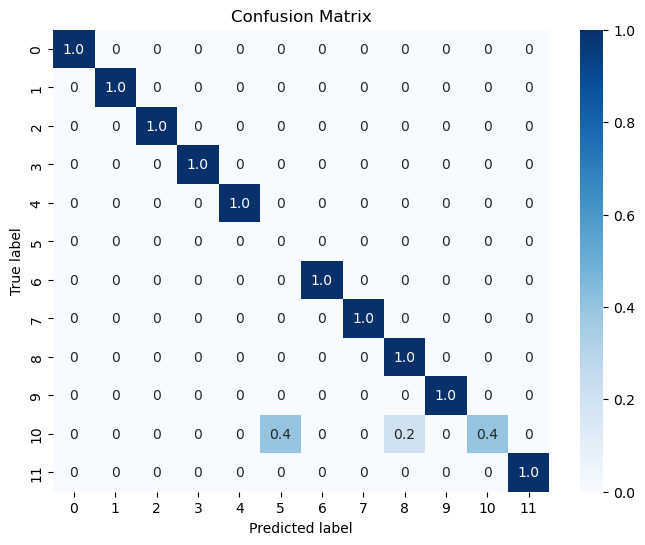

In [40]:
evaluation(y_test, y_pred2)

### 6 Features selection / Dimension reduction

#### Method 1 : Mutual information for feature selection

In [41]:
# Step 1: Calculate mutual information
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

Estimated mutual information between each feature and the target:
 [0.73097988 0.39621749 0.73009408 0.96729931 0.87459878 0.62855958
 0.75971341 0.74370256 0.82338203 0.74373117 0.85385555 0.32199759
 0.76161208 0.91494483 0.79309416 0.63102258 0.75645878 0.82635175
 0.87394475 0.77879642 0.77850212 0.47741502 0.57320535 0.9121777
 0.71988973 0.59142909 0.67203579 0.74129225 0.81791258 0.75949404
 0.74237683 0.40755346 0.74032914 0.9838903  0.80096067 0.63020461
 0.75641346 0.77191687 0.84707076 0.76049321 0.55762715 0.14193192
 0.85366334 1.01742381 0.96255879 0.84061272 0.756102   0.73450885
 0.77115749 0.71943128 0.07159878 0.         0.18307988 0.4119287
 0.83490749 0.52217684 0.5416322  0.19978126 0.32976945 0.22493087]



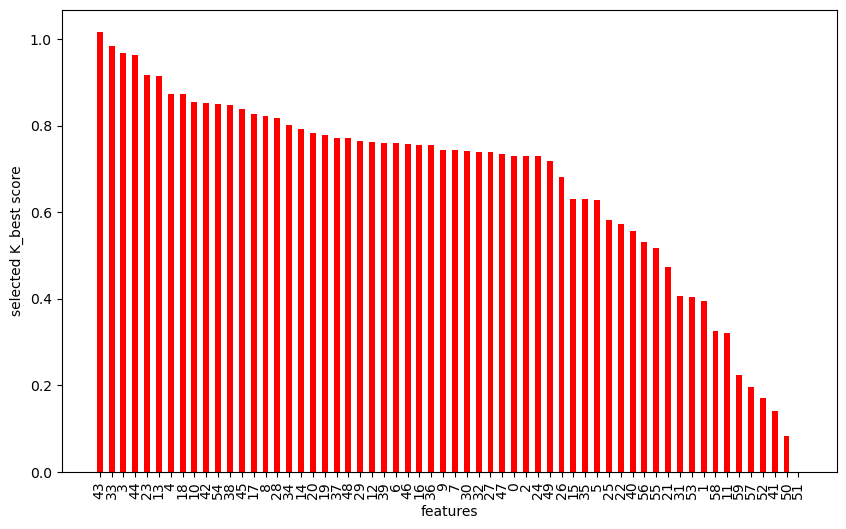

In [42]:
# Step 2: Select top 'k' features based on mutual information scores
k = 10  # number of top features to select
k_best = SelectKBest(score_func=mutual_info_classif, k=k)
k_best.fit(X_train_z, y_train)

# Get the indices sorted by most important to least important
indices = np.argsort(k_best.scores_)[::-1]

# Now plot
plt.figure(figsize=(10, 6))
plt.bar(range(0,60), k_best.scores_[indices], color='r', align='center',width = 0.5)
plt.xticks(range(0, len(indices)), indices, rotation=90) 

plt.xlabel('features')
plt.ylabel('selected K_best score')

plt.show()

In [43]:
# Step 3: Transform datasets to include only the selected features
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

In [44]:
# Step 4: Train a Random Forest Classifier using the reduced feature set
# Fit the model to the training data
grid.fit(X_train_best, y_train)
best_model = grid.best_estimator_

# Step 5: Evaluate the model
y_pred_MF = best_model.predict(X_test_best)

Accuracy score : 0.7916666666666666
F1 Score: 0.8166666666666668
recall Score: 0.7916666666666666
precision Score: 0.8541666666666666


/Users/djay/miniforge3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


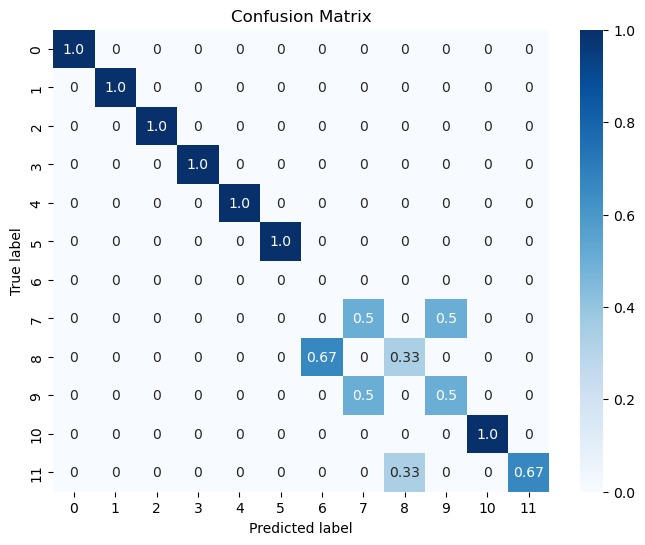

Predicted actions: [ 5.  5.  4.  9.  2.  8. 10.  9. 12.  6.  1. 11.  4.  3.  6. 12. 12.  8.
 10. 11.  3.  9.  2.  1.]


In [45]:
# Calculate accuracy
evaluation(y_test, y_pred_MF)
print("Predicted actions:", y_pred_MF)

#### Method 2 : PCA for dimension reduction

In [46]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_z)
X_test_pca = pca.transform(X_test_z)

print(f"Shape before PCA - Training: {X_train_z.shape}, Testing: {X_test_z.shape}")
print(f"Shape after PCA - Training: {X_train_pca.shape}, Testing: {X_test_pca.shape}")

Shape before PCA - Training: (96, 60), Testing: (24, 60)
Shape after PCA - Training: (96, 11), Testing: (24, 11)


In [47]:
#Train a Random Forest model on the PCA-transformed data
grid.fit(X_train_pca, y_train)
best_model = grid.best_estimator_
y_pred_PCA = best_model.predict(X_test_pca)

Accuracy score : 0.7916666666666666
F1 Score: 0.8194444444444445
recall Score: 0.7916666666666666
precision Score: 0.9166666666666666


/Users/djay/miniforge3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


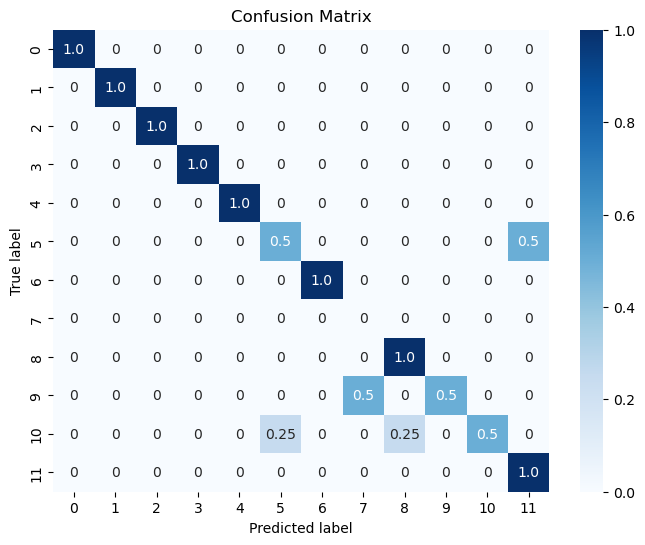

Predicted actions: [ 5.  5.  4.  7.  2. 10. 10.  7.  6. 11.  1. 11.  4.  3.  6. 11. 12. 10.
 10. 11.  3.  9.  2.  1.]


In [48]:
evaluation(y_test,y_pred_PCA)
print("Predicted actions:", y_pred_PCA)

#### Method 3 : Recursive Feature Elimination with Cross-Validation (RFECV)

In [49]:
rfecv_model = RFECV(estimator=RandomForestClassifier(random_state=42),
                    step=1,
                    cv=5,
                    scoring='accuracy')

rfecv_model.fit(X_train_z, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=42),
      scoring='accuracy')

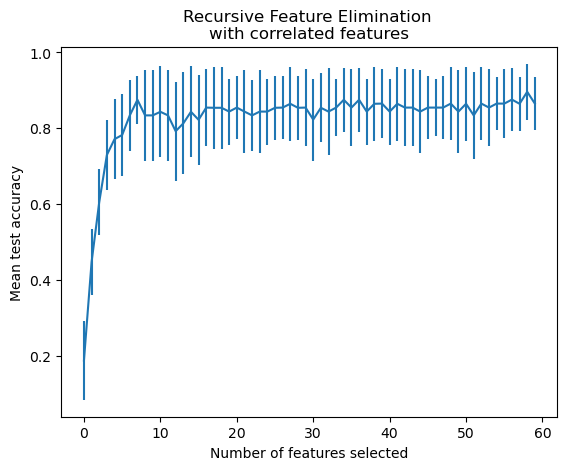

In [53]:
cv_results = pd.DataFrame(rfecv_model.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [54]:
# Transform the train and test sets using selected features
X_train_rfecv = rfecv_model.transform(X_train_z)
X_test_rfecv = rfecv_model.transform(X_test_z)

In [55]:
# Train a RandomForestClassifier on RFECV-selected features
grid.fit(X_train_rfecv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'log_loss'],
                         'max_depth': [None, 10, 20, 30, 40],
                         'max_features': ['sqrt', 'log2', 1, 5, 10, None],
                         'max_leaf_nodes': range(3, 15, 5),
                         'n_estimators': [10, 50, 100, 500]})

In [56]:
y_pred_RFECV = grid.predict(X_test_rfecv)

Accuracy score : 0.875
F1 Score: 0.8777777777777779
recall Score: 0.875
precision Score: 0.9375


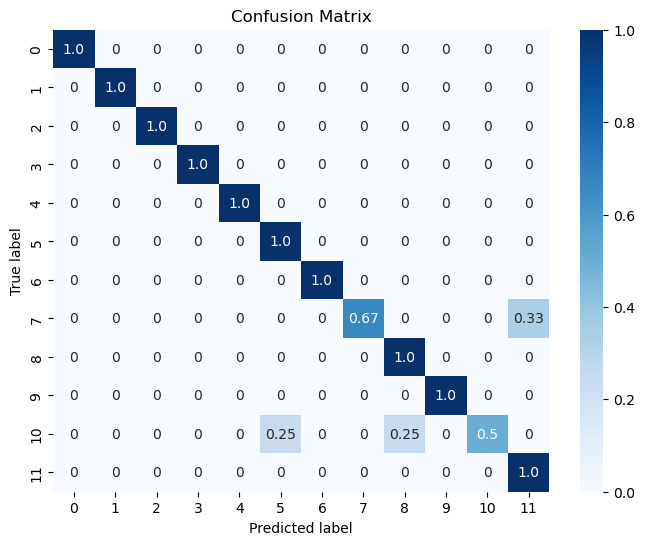

In [57]:
evaluation(y_test,y_pred_RFECV)